# Swire Modeling

Contribution
* Grif Brown - Overall project management, Prophet hyperparameters and dashboarding
* Katie O'Connor - Prophet Models (Weekly) and Write Ups
* Kim Buesser - Prophet Models (Top Breakages, Monthly and Location)
* Kyle Anderson - Random Forest, Write up and Experimentation with other models

### Introduction
Swire Coca-Cola is a major bottling partner of The Coca-Cola Company in the Western United States, operating 6 production plants across 13 states. These plants support the distribution, marketing, and production of Coca-Cola products.

### Project goal and business/analytic problems:
The main goal of this project is to improve maintenance efficiency and forecast potential downtimes across production locations by leveraging historical data on maintenance activity. From a business perspective, reducing unexpected maintenance events directly impacts productivity and cost-efficiency, helping Swire minimize the financial impact of equipment downtime. Analytically, the challenge lies in accurately predicting maintenance needs by location and equipment type, using time series models to capture both seasonality and trend patterns across complex datasets.

### Purpose of the notebook:
This goal of this notebook is to document and streamline the modeling process for maintenance forecasting across multiple locations. It includes data preparation, model tuning, and the application of multiple models to achieve reliable forecasts.

### Data preparation:
Data preparation included aggregating maintenance data at the weekly and monthly levels depending on the model requirements. Key variables were transformed to capture trends by location and equipment category, such as maintenance time aggregated per equipment type at each production site. Feature engineering involved adding seasonality and testing for both weekly, monthly, and yearly cycles to better capture periodic trends.

### Model Selection:
We want to be able to create a model that will identify if there are an anomalous amount of breakages compared to a normal breakage trend. Identifying true anomalies, i.e. true increases in number of breakages, compared to a normal breakage schedule appropriately is our performance metric. As this is an applied business problem, statistical metrics overall are less concerning than building a model that correctly identifies when a production line begins having an increased number of breakages. By doing this Swire can identify equipment that needs to be replaced before it becomes a bigger issue and creates extensive downtime.

The most appropriate models we identified were time series. These time series models can help us identify normal maintenance schedule and therefore flag moments when certain equipment is having an anomalous amount of maitenance. By creating this sort of flagging system we can notify Swire production on proper maintenance schedules to reduce production downtime. By having these flagging systems in place, the Swire plant will always be able to identify parts that need to be replaced before they become a more serious problem that results in a larger amount of production line downtime. This is what we identified as the best strategy to increase revenue across all plants.

The string cleaning and grouping the data by different time frames allowed us to get a more stable time series model. By identifying and experimenting with grouping by different periods (including weekly and monthly) we were able to test the time series model on these differenct periods which gave us surprisingly different results. Due to the weekly models having more overall periods they were more resilient and less affected by large outliers as compared to the monthly models. However the weekly models had much poorer R2 values as compared to the monthly models. Again this is when it becomes more important to use common sense and business understanding than statistical significance. We want to ensure that we can identify true anomalies and having a model that predicts on a more steady reliable trend is more important in this scenario than a model that has a higher R2 value but predicts a variable, unusual trend. Lastly, we used the trend during the time that had a normal breakdown schedule to predict for the future. It is essential that you remove spikes in breakdown schedule from the training data or else you will be unable to idenfity anomalies as the model will assume these breakdowns are normal part of the time series trend.

The hyperparameter tuning with the Prophet models included experimenting with many different seasonalities, additive vs multiplicative trends, using more or less training data, grouping by different periods as well as many other hyperparameters that you will see below. As mentioned previously when looking at equipment breakdown and breakages, where we envision Swire to use this in daily reporting, the weekly trends held a much more stable trend and therefore would be able to identify new anomalies, in terms of number of equipment breakdown, much better than their monthly counterparts. This would also allow us to flag anomalies to Swire at a more regular weekly schedule, as compared to the less regular and maybe less useful monthly schedule. Lastly it is very easy to make the model more sensitive to spikes in breakage by decreasing the confidence interval so that more data points have the opportunity to be identified as an anomaly (as we plan to flag only points that fall above the preicted confidence interval).

We have a working model that Swire could put into production today that would allow them to understand when piece of equipment should be replaced in a planned maintenance format before it creates an increased amount of production line downtime. If they act on our suggestions this will surely save Swire money over time and reduce production line downtime.

In [88]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.cloud import storage
import os
from io import StringIO
import json
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import mean_squared_error, r2_score
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import and clean data

In [90]:
# data upload
file_path = '/content/drive/MyDrive/Colab Notebooks/IWC_Work_Orders_Extract.csv'
df = pd.read_csv(file_path)


# Identify and convert any date columns based on their names
date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Filter data to include only entries from 2017 onwards
df = df[df['EXECUTION_START_DATE'] >= '2017-01-01']

In [91]:
# Ensure the date column is in the correct format for weekly aggregation
df['START_YEAR_WEEK'] = df['EXECUTION_START_DATE'].dt.to_period('W').dt.to_timestamp()

# Aggregate the data by week
weekly_data = df.groupby('START_YEAR_WEEK')['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()

# Rename columns to match Prophet's requirements
weekly_data.columns = ['ds', 'y']

# Display the first few rows of the prepared data for Prophet
weekly_data.head()

ds         y
0 2016-12-26    3049.0
1 2017-01-02   76692.4
2 2017-01-09  199296.8
3 2017-01-16   78359.4
4 2017-01-23   85138.0

## Prophet model across all plants

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/7y83ujwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/mki1s9n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83050', 'data', 'file=/tmp/tmpd1hzcq62/7y83ujwu.json', 'init=/tmp/tmpd1hzcq62/mki1s9n4.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_model4ial0v7o/prophet_model-20241106062734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 2024586460.0463207
R-squared: -0.31950957694080406


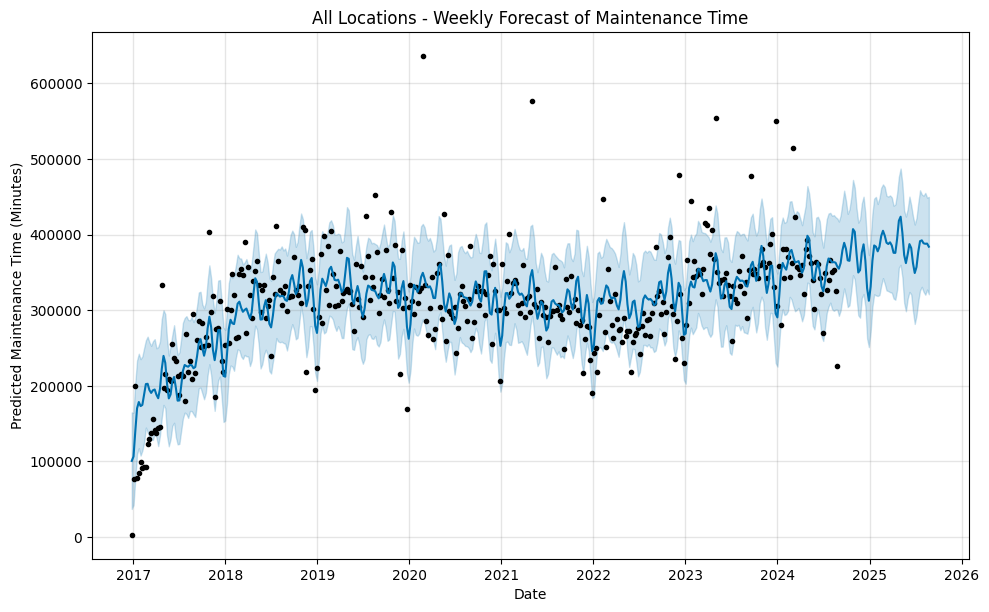

In [92]:
# Initialize the Prophet model
model = Prophet()

# Fit the model on the aggregated weekly data
model.fit(weekly_data)

# Define the prediction horizon
future = model.make_future_dataframe(periods=52, freq='W')

# Generate forecast
forecast = model.predict(future)

# Define the validation period
validation_period = weekly_data['ds'][-12:]
actual_values = weekly_data.set_index('ds').loc[validation_period, 'y']
predicted_values = forecast.set_index('ds').loc[validation_period, 'yhat']

# Calculate performance metrics
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

# Output the performance metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
fig = model.plot(forecast)
plt.title("All Locations - Weekly Forecast of Maintenance Time")
plt.xlabel("Date")
plt.ylabel("Predicted Maintenance Time (Minutes)")
plt.show()

The weekly Prophet model, using an extended 12-week validation period, produced a Mean Squared Error (MSE) of 250,877,823.37 and an R-squared of -0.32. The low R-squared is likely due to outliers being captured in the data. From an overall trend standpoint though, this initial model does a decent job of capturing and predicting future trends that align with what we see historically.

## Prophet model by production location and Week

Next, we chose to break it down by production location and week.  Since each location has different production demands and patterns, this is key to extracting meaningful insight.

In [93]:
# Aggregate data by Production Location and Week
location_weekly_data = df.groupby([pd.Grouper(key='EXECUTION_START_DATE', freq='W'), 'PRODUCTION_LOCATION'])['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()

# Rename columns for Prophet compatibility
location_weekly_data.columns = ['ds', 'PRODUCTION_LOCATION', 'y']

# Display the first few rows to confirm
print(location_weekly_data.head())

          ds PRODUCTION_LOCATION         y
0 2017-01-01         SILVERSTONE    3049.0
1 2017-01-08         SILVERSTONE   76692.4
2 2017-01-15         SILVERSTONE  199296.8
3 2017-01-22         SILVERSTONE   78359.4
4 2017-01-29         SILVERSTONE   85138.0


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/9ie2oszo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/eiyucauo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64913', 'data', 'file=/tmp/tmpd1hzcq62/9ie2oszo.json', 'init=/tmp/tmpd1hzcq62/eiyucauo.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelszufgi8y/prophet_model-20241106062740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing location: SILVERSTONE


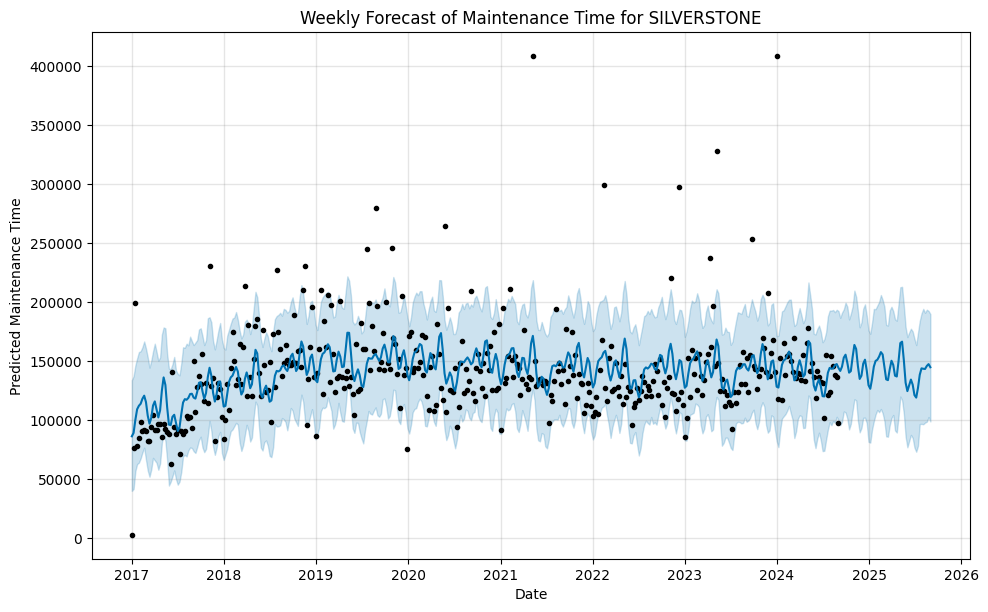

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/9tjurn5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/xx9ely79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17943', 'data', 'file=/tmp/tmpd1hzcq62/9tjurn5b.json', 'init=/tmp/tmpd1hzcq62/xx9ely79.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_model_61k9guo/prophet_model-20241106062741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing location: MONZA


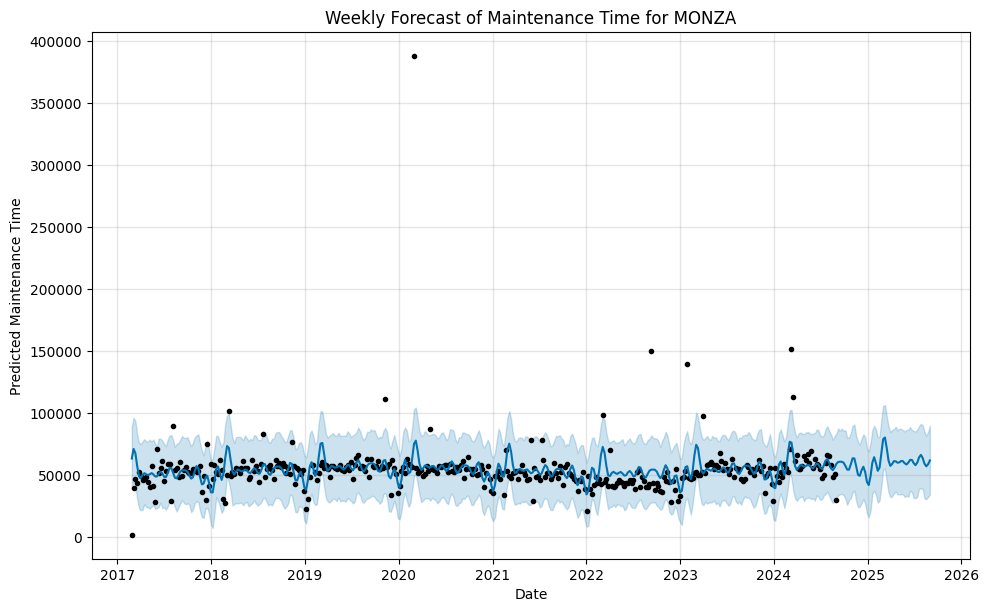

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/8mmnab_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/y6u7v8pw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4171', 'data', 'file=/tmp/tmpd1hzcq62/8mmnab_o.json', 'init=/tmp/tmpd1hzcq62/y6u7v8pw.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_model5bs3gj_z/prophet_model-20241106062742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing location: SUZUKA


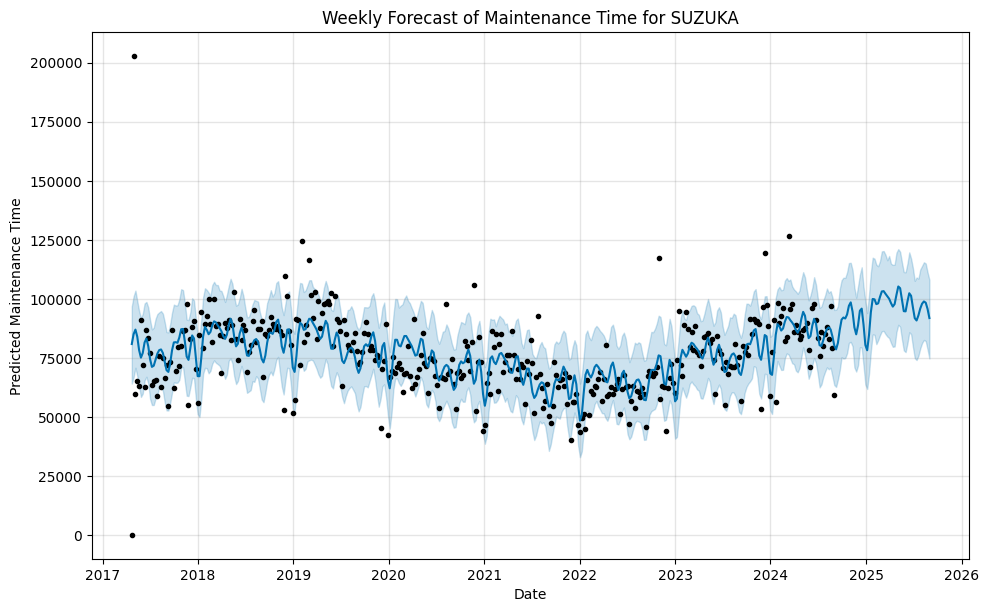

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/n8gcl3_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/q3zqksfa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9711', 'data', 'file=/tmp/tmpd1hzcq62/n8gcl3_r.json', 'init=/tmp/tmpd1hzcq62/q3zqksfa.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modeltvyduzl4/prophet_model-20241106062743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing location: ROMA


06:27:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


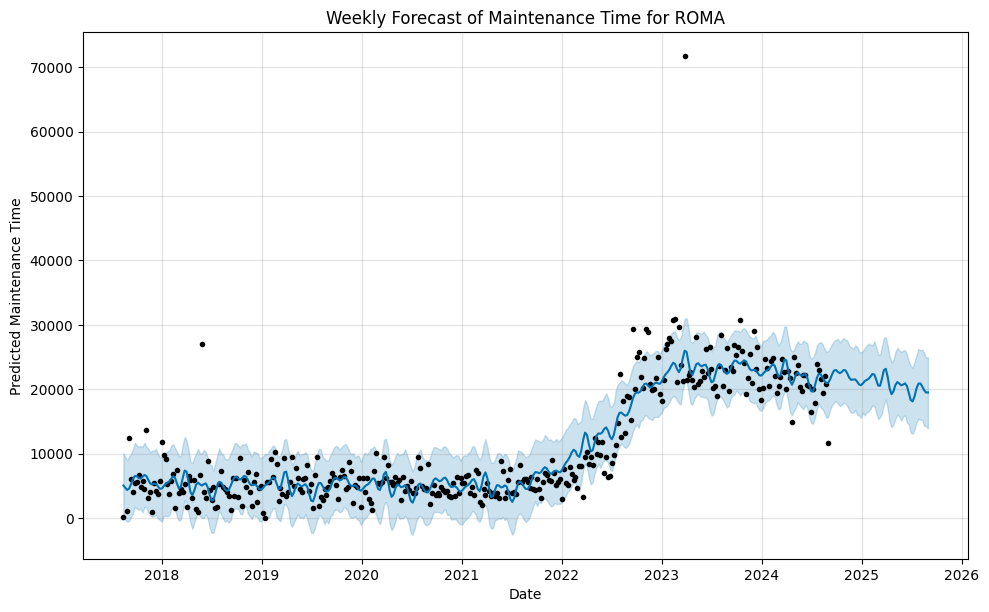

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/1_6vxdpq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/p6lpjcpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59279', 'data', 'file=/tmp/tmpd1hzcq62/1_6vxdpq.json', 'init=/tmp/tmpd1hzcq62/p6lpjcpv.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelfzt65_01/prophet_model-20241106062744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing location: COTA


06:27:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


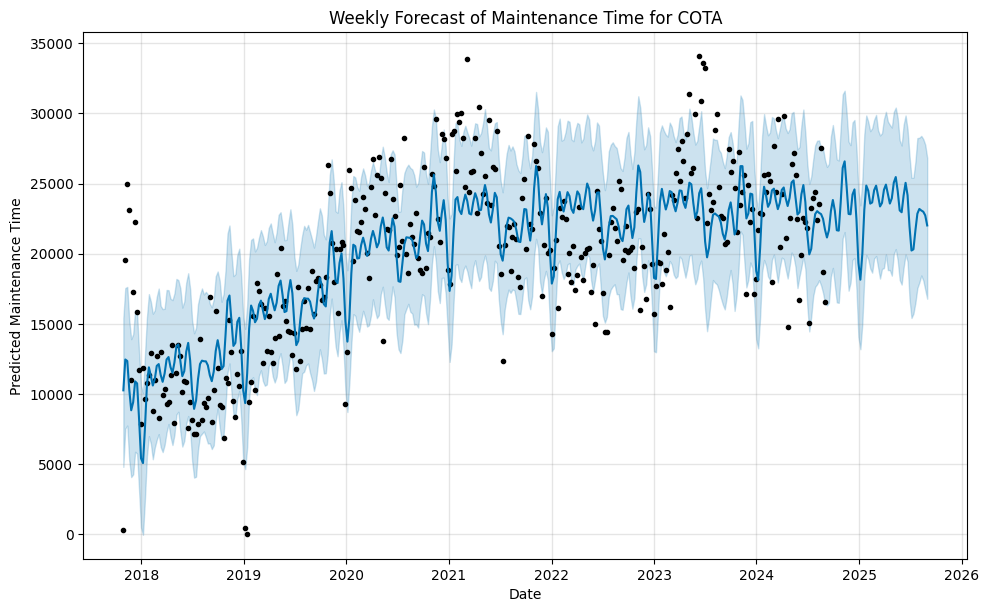

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/kagh9n5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/2edp8w3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76621', 'data', 'file=/tmp/tmpd1hzcq62/kagh9n5h.json', 'init=/tmp/tmpd1hzcq62/2edp8w3j.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modeln09rom8w/prophet_model-20241106062745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing location: MONACO


06:27:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


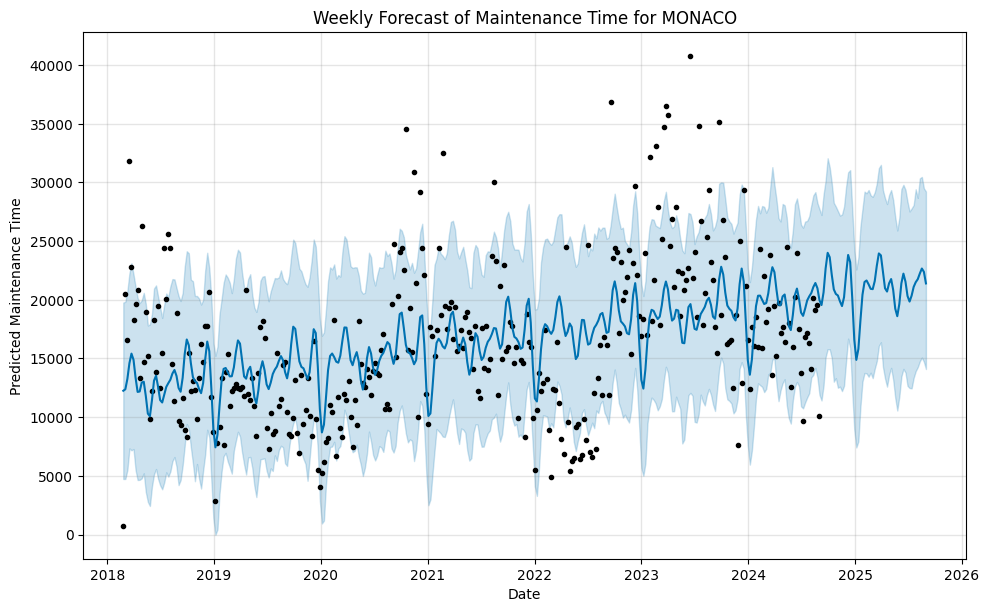

In [94]:
# Dictionary to store forecasts and performance metrics by location
forecasts_by_location = {}
prophet_metrics_by_location = {}

# Loop through each production location
for location in location_weekly_data['PRODUCTION_LOCATION'].unique():
    print(f"Processing location: {location}")

    # Filter data for the current location
    location_data = location_weekly_data[location_weekly_data['PRODUCTION_LOCATION'] == location]

    # Initialize and fit Prophet model
    model = Prophet()
    model.fit(location_data[['ds', 'y']])

    # Define the prediction horizon
    future = model.make_future_dataframe(periods=52, freq='W')

    # Generate forecast
    forecast = model.predict(future)

    # Store forecast in the dictionary
    forecasts_by_location[location] = forecast

    # Define the validation period
    validation_period = location_data['ds'][-12:]
    actual_values = location_data.set_index('ds').loc[validation_period, 'y']
    predicted_values = forecast.set_index('ds').loc[validation_period, 'yhat']

    # Plot the forecast for the current location
    fig = model.plot(forecast)
    plt.title(f"Weekly Forecast of Maintenance Time for {location}")
    plt.xlabel("Date")
    plt.ylabel("Predicted Maintenance Time")
    plt.show()

In [95]:
# Dictionary to store performance metrics by location
prophet_metrics_by_location = {}

# Loop through each production location to calculate performance metrics
for location, forecast in forecasts_by_location.items():
    print(f"Calculating performance metrics for location: {location}")

    # Retrieve the actual data for the validation period
    location_data = location_weekly_data[location_weekly_data['PRODUCTION_LOCATION'] == location]
    validation_period = location_data['ds'][-12:]  # Last 12 weeks
    actual_values = location_data.set_index('ds').loc[validation_period, 'y']
    predicted_values = forecast.set_index('ds').loc[validation_period, 'yhat']

    # Calculate MSE and R-squared
    mse = mean_squared_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)

    # Store metrics in the dictionary
    prophet_metrics_by_location[location] = {'MSE': mse, 'R2': r2}

    # Output the performance metrics for each location
    print(f"Location: {location}, MSE: {mse:.2f}, R2: {r2:.2f}")

Calculating performance metrics for location: SILVERSTONE
Location: SILVERSTONE, MSE: 364138188.84, R2: -0.22
Calculating performance metrics for location: MONZA
Location: MONZA, MSE: 90414641.28, R2: -0.02
Calculating performance metrics for location: SUZUKA
Location: SUZUKA, MSE: 56976885.39, R2: 0.40
Calculating performance metrics for location: ROMA
Location: ROMA, MSE: 9858208.72, R2: 0.00
Calculating performance metrics for location: COTA
Location: COTA, MSE: 9305687.97, R2: 0.16
Calculating performance metrics for location: MONACO
Location: MONACO, MSE: 25057064.48, R2: -0.59


The 24-week validation results for each location show modest performance, with SUZUKA achieving the highest R-squared at 0.40, indicating some level of predictive success.  That being said, we know that this is once again due to outliers.  The trend line looks decent among most plants.

## Prophet model by location with yearly seasonality

Below, we begin to experiment with different hyper-paremeters such as seaonality to see if this has any impact on what we see trend wise.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/ebr_1yrs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/0pfn2oxu.json


Processing location: SILVERSTONE


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82422', 'data', 'file=/tmp/tmpd1hzcq62/ebr_1yrs.json', 'init=/tmp/tmpd1hzcq62/0pfn2oxu.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modeloyvlks3f/prophet_model-20241106062746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


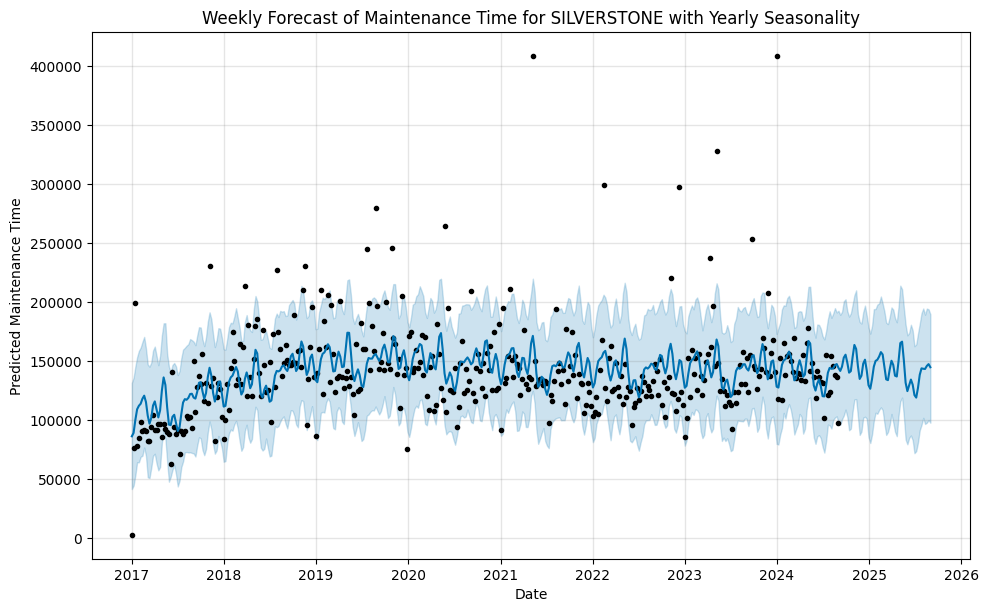

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/a_z7s3nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/6gn_0ti7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10194', 'data', 'file=/tmp/tmpd1hzcq62/a_z7s3nn.json', 'init=/tmp/tmpd1hzcq62/6gn_0ti7.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelsms09cbk/prophet_model-20241106062747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing location: MONZA


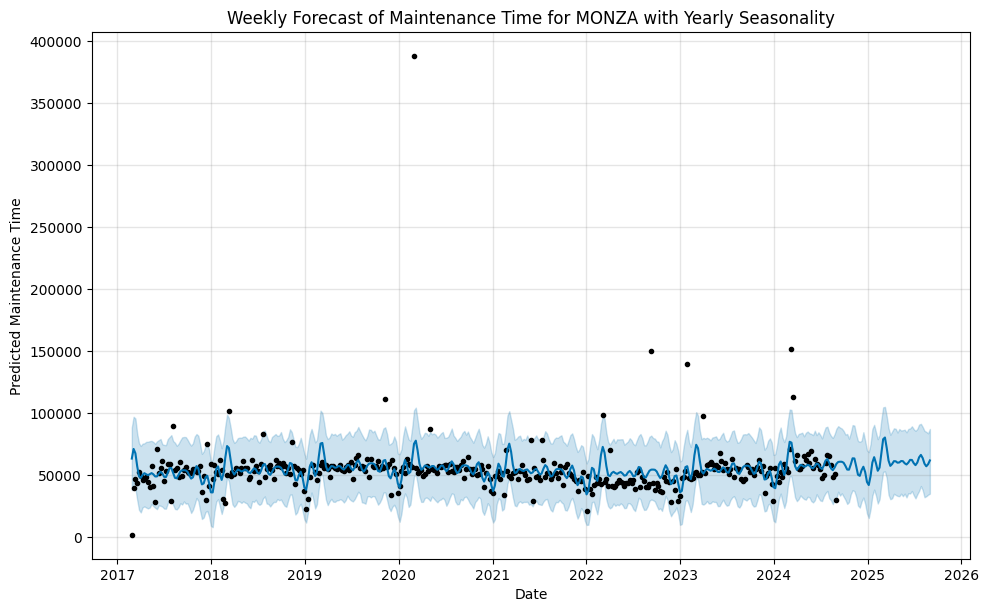

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/1p7l07do.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/l27w1f38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34960', 'data', 'file=/tmp/tmpd1hzcq62/1p7l07do.json', 'init=/tmp/tmpd1hzcq62/l27w1f38.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelqcsul383/prophet_model-20241106062748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing location: SUZUKA


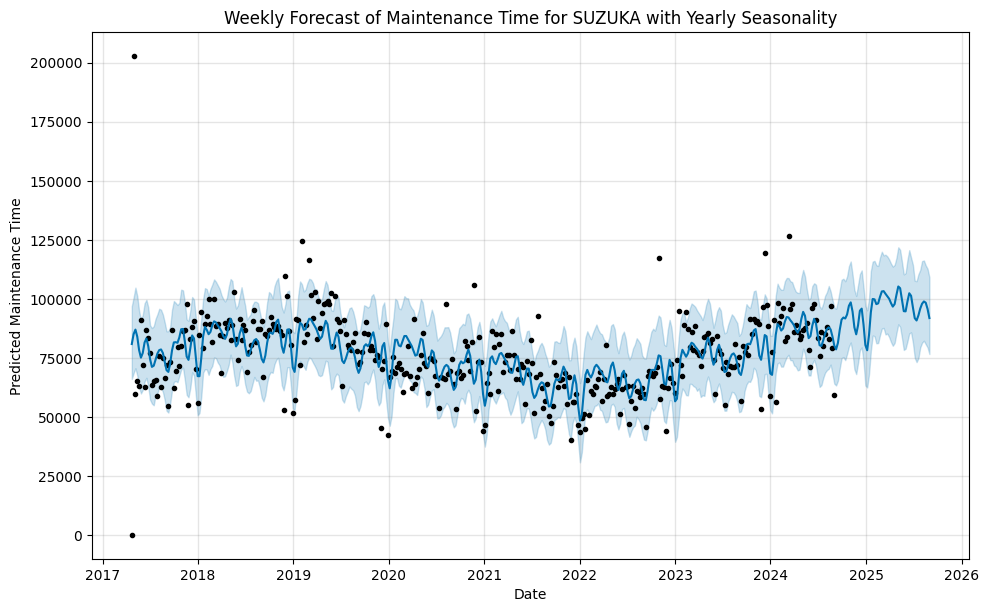

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/y2644ewb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/eq5pl3hc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76133', 'data', 'file=/tmp/tmpd1hzcq62/y2644ewb.json', 'init=/tmp/tmpd1hzcq62/eq5pl3hc.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_model1rh04l_w/prophet_model-20241106062749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing location: ROMA


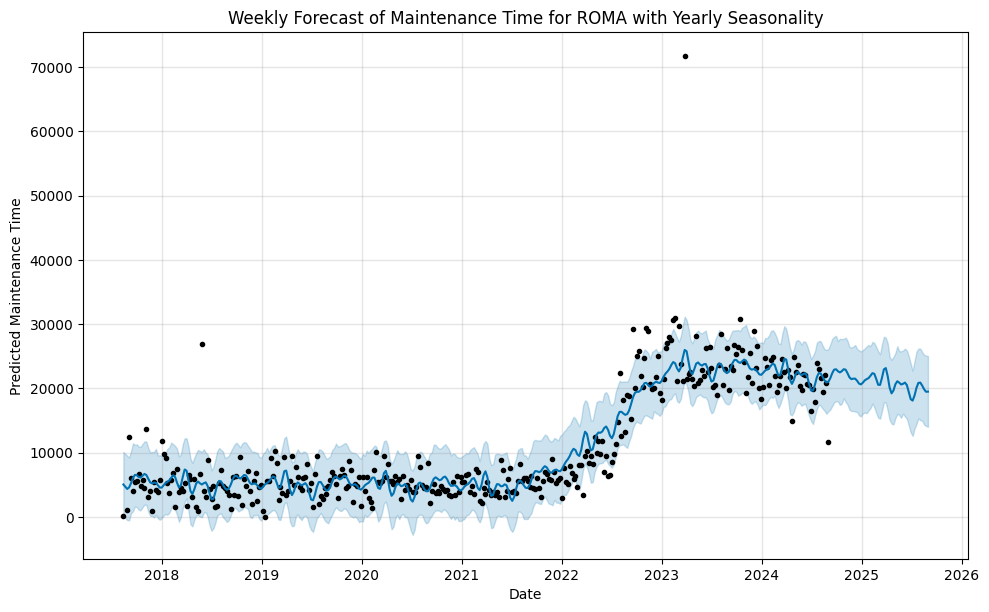

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/sktahjfv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/_kj4g0wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81555', 'data', 'file=/tmp/tmpd1hzcq62/sktahjfv.json', 'init=/tmp/tmpd1hzcq62/_kj4g0wt.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelht6ig8t3/prophet_model-20241106062749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing location: COTA


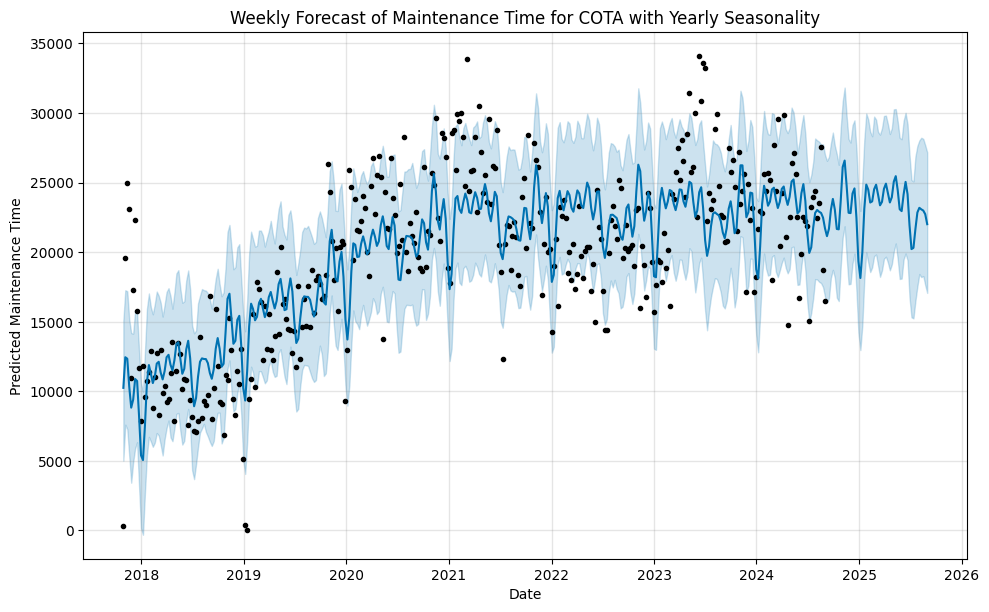

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/eds6mqni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/g0ldjo1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26464', 'data', 'file=/tmp/tmpd1hzcq62/eds6mqni.json', 'init=/tmp/tmpd1hzcq62/g0ldjo1j.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelejdmnf7y/prophet_model-20241106062750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing location: MONACO


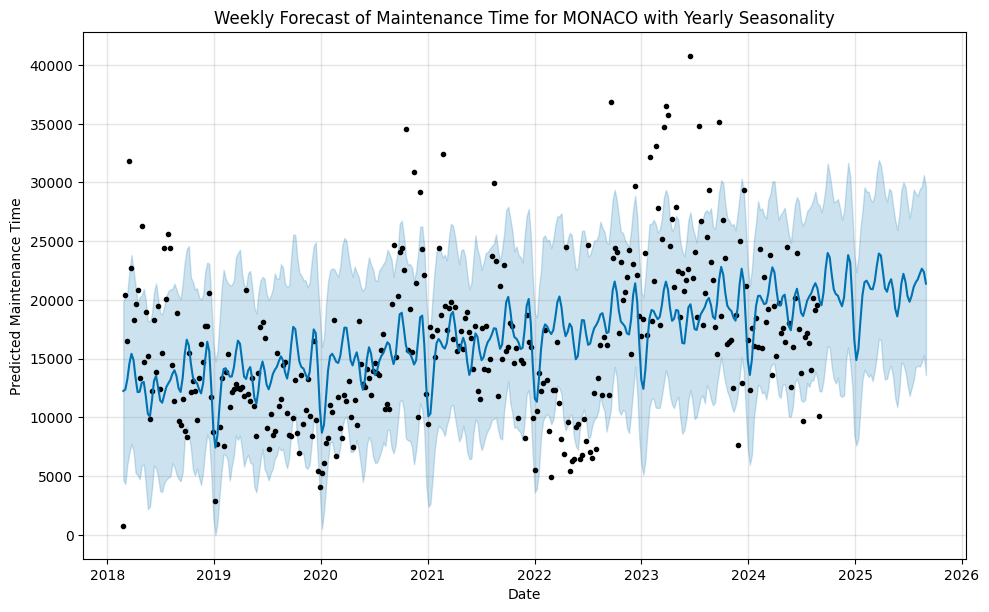

In [96]:
# Dictionary to store forecasts and performance metrics by location
forecasts_by_location = {}
prophet_metrics_by_location = {}

# Loop through each production location
for location in location_weekly_data['PRODUCTION_LOCATION'].unique():
    print(f"Processing location: {location}")

    # Filter data for the current location
    location_data = location_weekly_data[location_weekly_data['PRODUCTION_LOCATION'] == location]

    # Initialize and fit Prophet model with yearly seasonality enabled
    model = Prophet(yearly_seasonality=True)
    model.fit(location_data[['ds', 'y']])

    # Define the prediction horizon
    future = model.make_future_dataframe(periods=52, freq='W')

    # Generate forecast
    forecast = model.predict(future)

    # Store forecast in the dictionary
    forecasts_by_location[location] = forecast

    # Define the validation period
    validation_period = location_data['ds'][-12:]
    actual_values = location_data.set_index('ds').loc[validation_period, 'y']
    predicted_values = forecast.set_index('ds').loc[validation_period, 'yhat']

    # Plot the forecast for the current location
    fig = model.plot(forecast)
    plt.title(f"Weekly Forecast of Maintenance Time for {location} with Yearly Seasonality")
    plt.xlabel("Date")
    plt.ylabel("Predicted Maintenance Time")
    plt.show()

As we can see above, the yearly seasonality captured in future trends seems to look fairly similar to larger trends that are visible in previous years.

In [97]:
# Dictionary to store performance metrics by location
prophet_metrics_by_location = {}

# Loop through each production location to calculate performance metrics
for location, forecast in forecasts_by_location.items():
    # Retrieve the actual data for the validation period
    location_data = location_weekly_data[location_weekly_data['PRODUCTION_LOCATION'] == location]
    validation_period = location_data['ds'][-12:]  # Last 12 weeks
    actual_values = location_data.set_index('ds').loc[validation_period, 'y']
    predicted_values = forecast.set_index('ds').loc[validation_period, 'yhat']

    # Calculate MSE and R-squared
    mse = mean_squared_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)

    # Store metrics in the dictionary
    prophet_metrics_by_location[location] = {'MSE': mse, 'R2': r2}

# Display overall performance metrics by location
print("\nOverall Performance Metrics by Location:")
for location, metrics in prophet_metrics_by_location.items():
    print(f"{location}: MSE = {metrics['MSE']:.2f}, R-squared = {metrics['R2']:.2f}")


Overall Performance Metrics by Location:
SILVERSTONE: MSE = 364138188.84, R-squared = -0.22
MONZA: MSE = 90414641.28, R-squared = -0.02
SUZUKA: MSE = 56976885.39, R-squared = 0.40
ROMA: MSE = 9858208.72, R-squared = 0.00
COTA: MSE = 9305687.97, R-squared = 0.16
MONACO: MSE = 25057064.48, R-squared = -0.59


The performance metrics look pretty similar to the previous model, without the yearly seasonality. Again, this is not something we want to focus on in too much depth because the R-squared is getting pulled down by these outliers.

## Maintenance cost using the prophet model

Below, we have a prophet model implementing an abrbitary cost maintenance of $2/minute.  This can be something that we explore in further depth down the road to draw tangible insight from on a financial business side for Swire.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/6z0am_51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/ln7zo88p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99132', 'data', 'file=/tmp/tmpd1hzcq62/6z0am_51.json', 'init=/tmp/tmpd1hzcq62/ln7zo88p.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelx3virjg_/prophet_model-20241106062757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


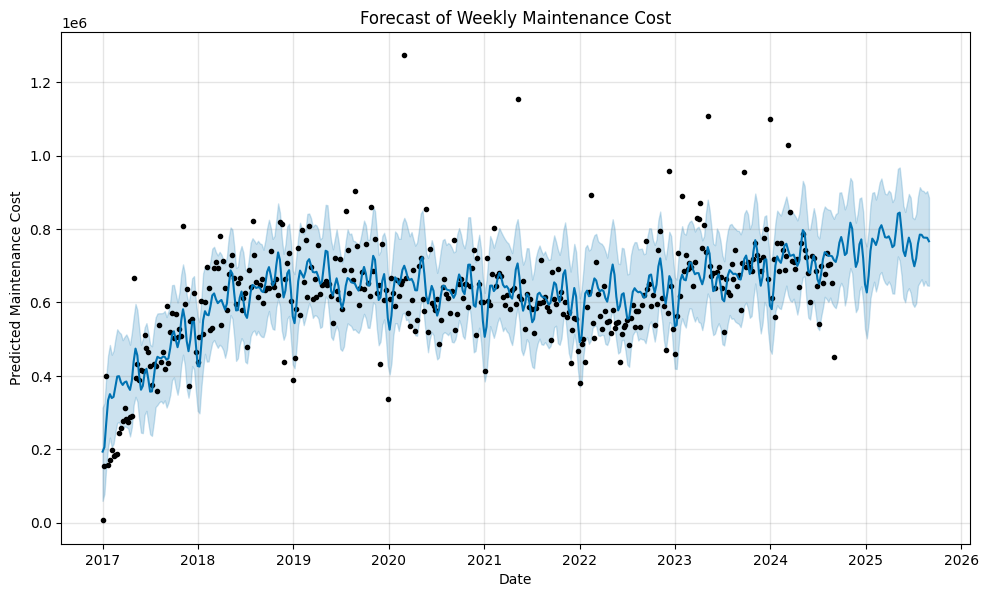

In [98]:
# Define cost per minute
cost_per_minute = 2

# Calculate maintenance cost based on work minutes
df['maintenance_cost'] = df['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute

# Aggregate weekly maintenance cost
weekly_cost = df.resample('W', on='EXECUTION_START_DATE')['maintenance_cost'].sum().reset_index()

# Rename columns for Prophet
weekly_cost.columns = ['ds', 'y']

# Initialize and fit the Prophet model
model_cost = Prophet()
model_cost.fit(weekly_cost)

# Generate future dates for the forecast
future_cost = model_cost.make_future_dataframe(periods=52, freq='W')  # 52 weeks into the future

# Forecast maintenance cost
forecast_cost = model_cost.predict(future_cost)

# Plot the forecast
fig = model_cost.plot(forecast_cost)
plt.title("Forecast of Weekly Maintenance Cost")
plt.xlabel("Date")
plt.ylabel("Predicted Maintenance Cost")
plt.show()

# Time Series Prediction on Equipment/Breakdown Level
Next we are looking into building time series trends and predictions based on normal maintenance schedule to be able to identify when a piece of equipment may need to be replaced by having unusually high number of breakdowns. This anomaly detection model will allow us to identify an unusually high number of breakdowns and flag it to the production line team. With this knowledge, the team can potentially replace equipment before it becomes a bigger issue that causes more frequent breakdowns.

## String Cleaning and adding time variables

In [99]:
df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = df['FUNCTIONAL_AREA_NODE_2_MODIFIED'].str.replace(r' |&|SYSTEMS|G812|TREATMENT|,|-|L(1|2|4|6)|LINES?(1|8|2|3)|2|9|1|410|3|PRD|S$', r'', regex=True)
def label_value(x):
    if x == 'BTL_PET_LINE':
        return 'PETBOTTLELINES'
    else:
        return x

df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = df['FUNCTIONAL_AREA_NODE_2_MODIFIED'].apply(label_value)
df['EXECUTION_START_DATE'] = pd.to_datetime(df['EXECUTION_START_DATE'])
df['Month'] = df['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
df['Week'] = df['EXECUTION_START_DATE'].dt.to_period('W').dt.to_timestamp()

## Plot to Understand Normal Breakdown Schedule Time
We can see that starting in 2023 the amount of breakdowns skyrocketed compared to the previous 6 years. I want to grab the trends from everything before 2023 to estimate a normal breakdown schedule and use those trends to predict for the future.

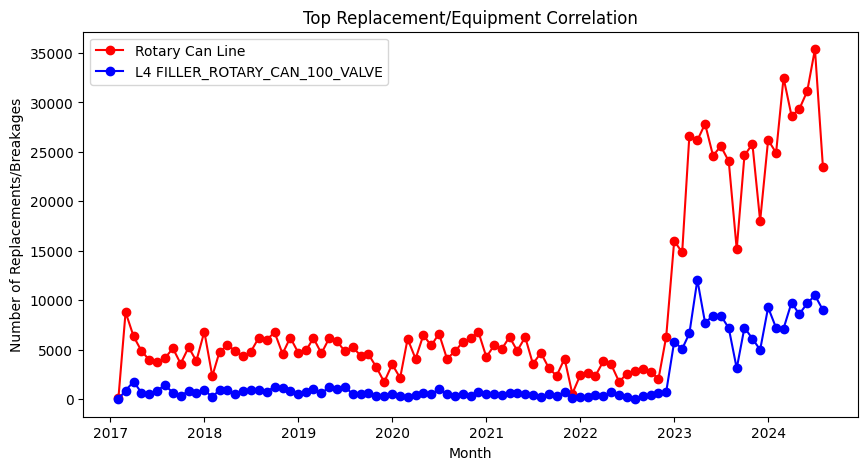

In [100]:
plot_df = df[df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE'].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
plot_df = plot_df.reset_index()
plt.figure(figsize=(10, 5))  # Set the figure size
break_plot_df = df[df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE'].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
break_plot_df = break_plot_df.reset_index()
plt.plot(break_plot_df['Month'], break_plot_df['ACTUAL_WORK_IN_MINUTES'], label='Rotary Can Line', marker='o', linestyle='-', color='r')
plt.plot(plot_df['Month'], plot_df['ACTUAL_WORK_IN_MINUTES'], label='L4 FILLER_ROTARY_CAN_100_VALVE', marker='o', linestyle='-', color='b')
# Line plot with markers
plt.title('Top Replacement/Equipment Correlation')
plt.xlabel('Month')
plt.ylabel('Number of Replacements/Breakages')
plt.legend()
plt.show()

So we can see here that starting in 2023 there was a stark increase in maitenance and breakdowns. Therefore, I feel that it is better to train the model on normal breakdown trends of the years preceeding 2023 to ensure that we are catching true anomalies.

## Trend before 2023

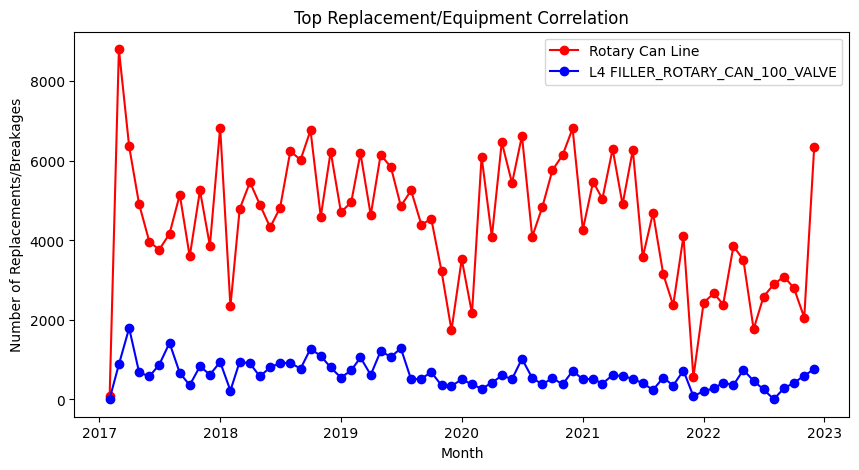

In [101]:
plot_df = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE') &
    (df['Month'] < '2023-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
plot_df = plot_df.reset_index()

break_plot_df = df[
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE') &
    (df['Month'] < '2023-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
break_plot_df = break_plot_df.reset_index()

# Plotting
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(break_plot_df['Month'], break_plot_df['ACTUAL_WORK_IN_MINUTES'], label='Rotary Can Line', marker='o', linestyle='-', color='r')
plt.plot(plot_df['Month'], plot_df['ACTUAL_WORK_IN_MINUTES'], label='L4 FILLER_ROTARY_CAN_100_VALVE', marker='o', linestyle='-', color='b')
plt.title('Top Replacement/Equipment Correlation')
plt.xlabel('Month')
plt.ylabel('Number of Replacements/Breakages')
plt.legend()
plt.show()

This is the data that we plan to train these specific models on knowing that we don't want to train the time series models on anomalous breakdown trends.

## Prophet for Rotary Can Line before 2023 Monthly

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/p228244w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/j1u8zf8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87139', 'data', 'file=/tmp/tmpd1hzcq62/p228244w.json', 'init=/tmp/tmpd1hzcq62/j1u8zf8t.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelthkl6ytz/prophet_model-20241106062801.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:28:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 1894663.3188697603
R-squared: 0.28472669566221676


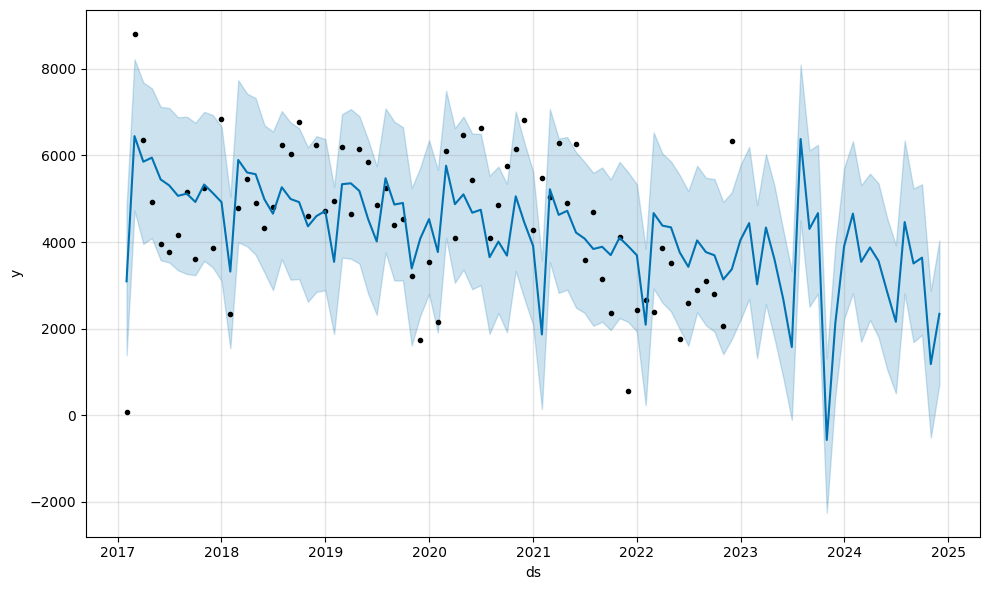

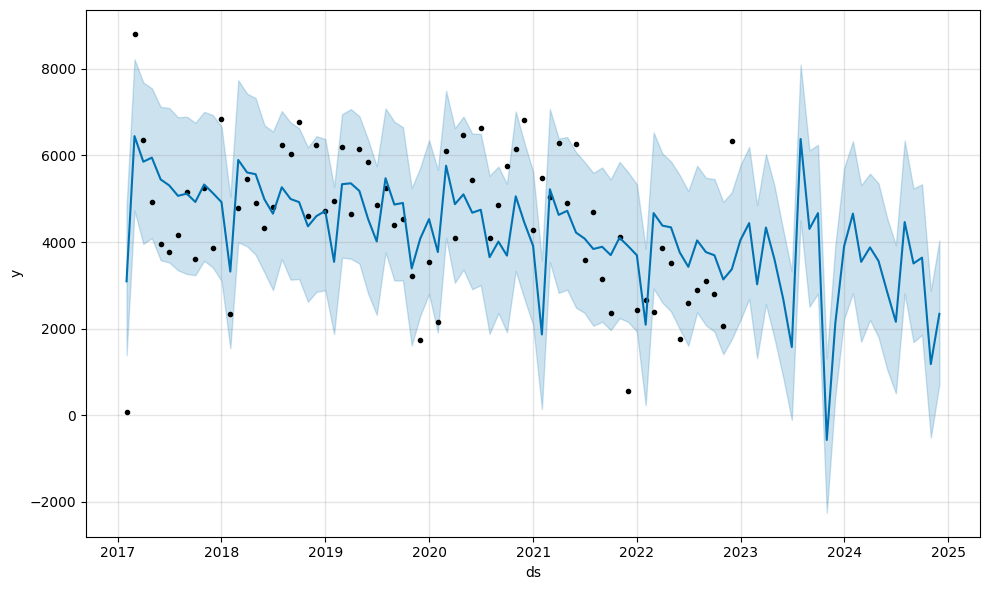

In [102]:
rotary_can_ts = df[
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE') &
    (df['Month'] < '2023-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
rotary_can_ts = rotary_can_ts.reset_index()

rotary_can_ts['Month'] = pd.to_datetime(rotary_can_ts['Month'])

# Prepare the data for Prophet
prophet_data = rotary_can_ts.rename(columns={'Month': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=24, freq='M')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Month']]
actual = rotary_can_ts.set_index('Month')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)

## Hyperparameter tuning to improve R2

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/b4w7p1_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/thrv3dk9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85250', 'data', 'file=/tmp/tmpd1hzcq62/b4w7p1_g.json', 'init=/tmp/tmpd1hzcq62/thrv3dk9.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_model1v9vn7sn/prophet_model-20241106062803.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:28:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 1815706.69163977
R-squared: 0.31453440191572235


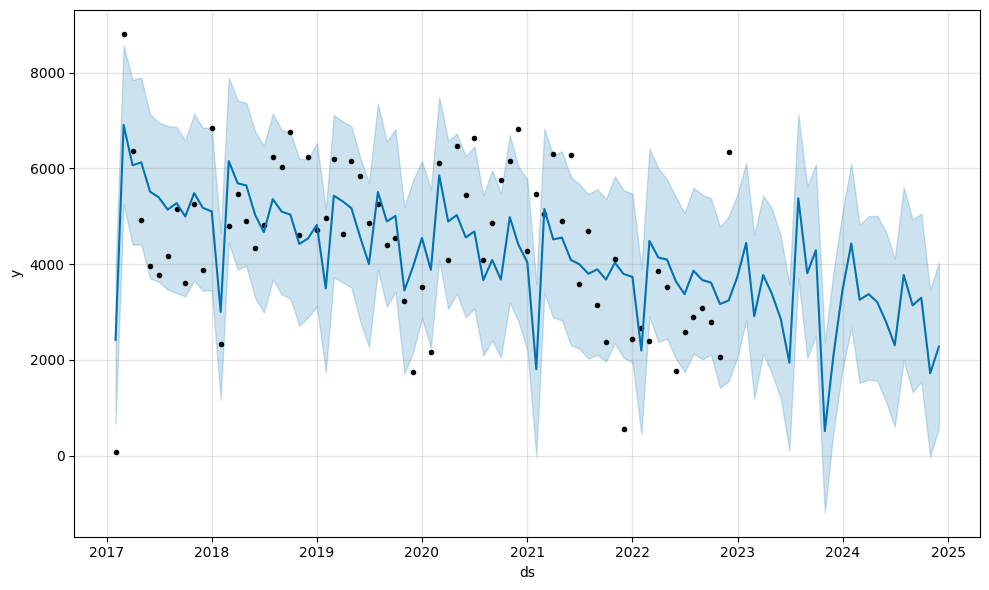

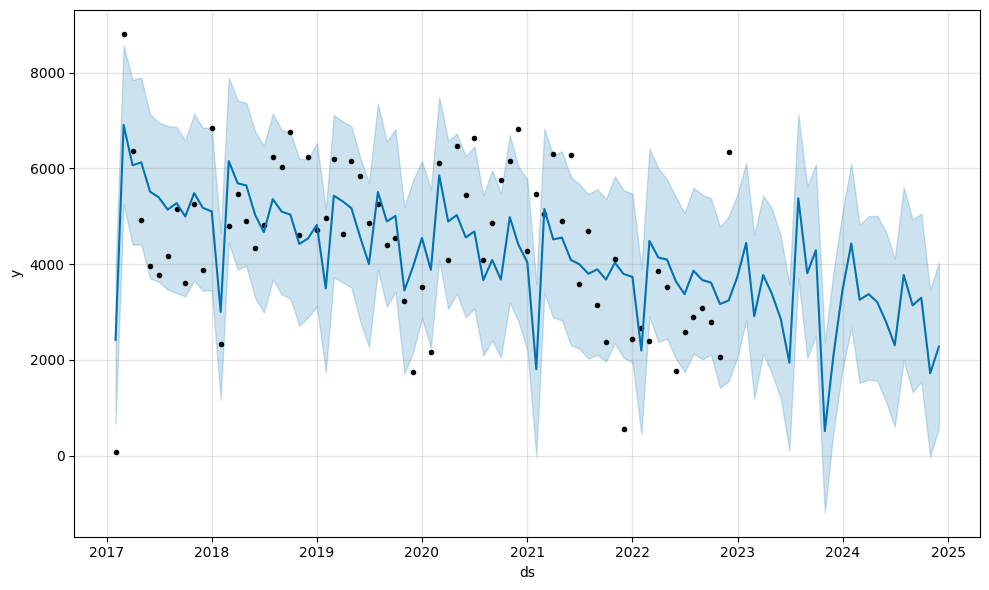

In [103]:
# Prepare the data for Prophet
prophet_data = rotary_can_ts.rename(columns={'Month': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Fit the Prophet model
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
# model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Add monthly seasonality if applicable
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=24, freq='M')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Month']]
actual = rotary_can_ts.set_index('Month')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)

## Testing Weekly Trend

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/kprtntde.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/g41ecl9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74607', 'data', 'file=/tmp/tmpd1hzcq62/kprtntde.json', 'init=/tmp/tmpd1hzcq62/g41ecl9g.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelst10c5h4/prophet_model-20241106062804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 489237.3741489961
R-squared: 0.08120351686730676


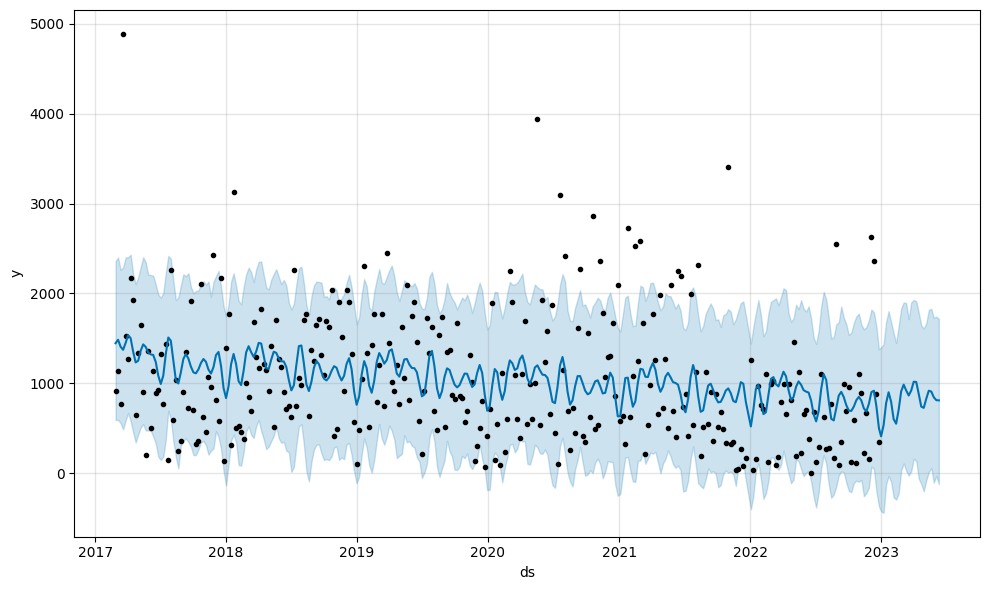

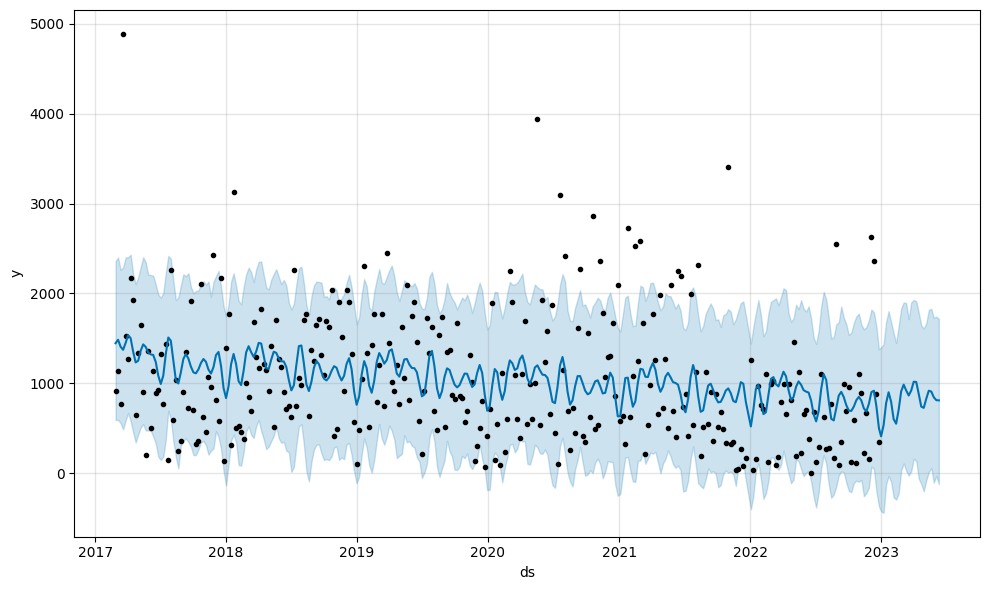

In [104]:
rotary_can_ts = df[
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE') &
    (df['Week'] < '2023-01-01')
].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
rotary_can_ts = rotary_can_ts.reset_index()

rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

# Prepare the data for Prophet
prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=24, freq='W')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
actual = rotary_can_ts.set_index('Week')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)

While the monthly models have much higher R2 values, the weekly trend is not only more stable over time but also more stable into its future predictions. We want a model that reliably identifies anomalies in terms of breakdowns rather than maintains a high R2 (ideally we have both but in this situation that is not the case).

## Prophet for L4 FILLER_ROTARY_CAN_100_VALVE before 2023

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/khgp8tjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/nf33bcma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38051', 'data', 'file=/tmp/tmpd1hzcq62/khgp8tjj.json', 'init=/tmp/tmpd1hzcq62/nf33bcma.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelqufgvz9p/prophet_model-20241106062805.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:28:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 61527.57328306916
R-squared: 0.4343681921978796


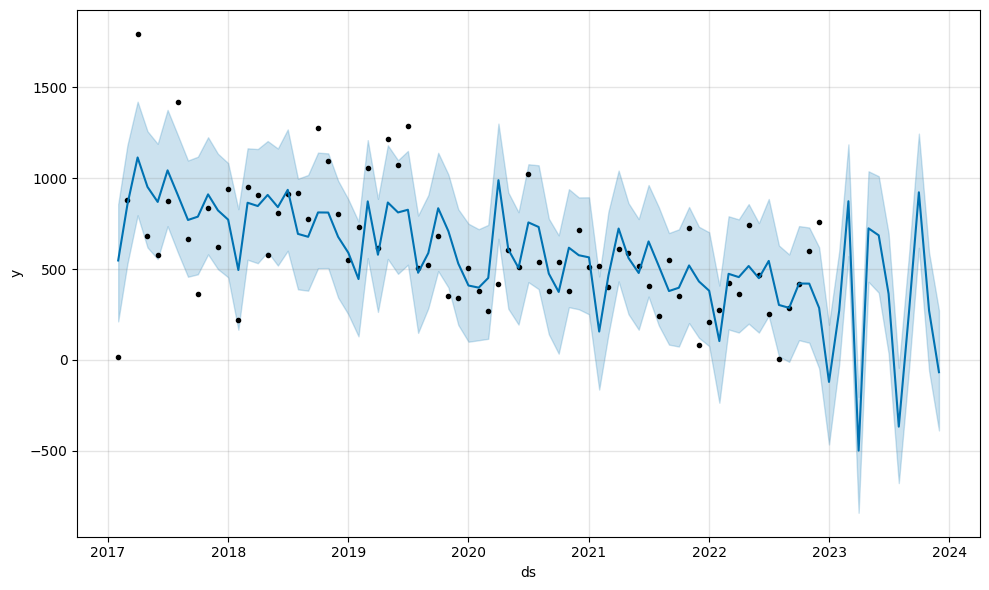

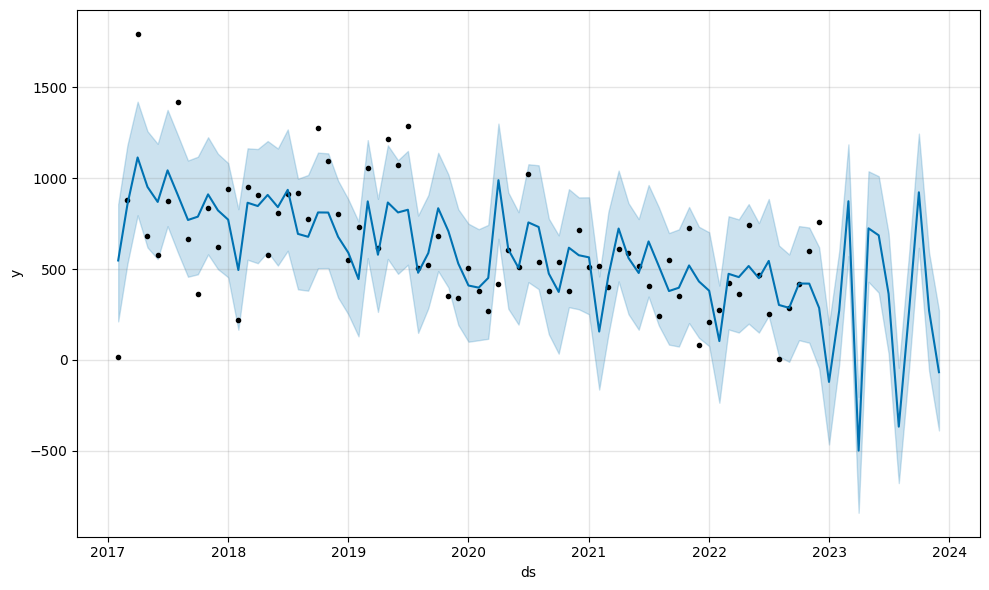

In [105]:
l4_filler = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE') &
    (df['Month'] < '2023-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
l4_filler = l4_filler.reset_index()

l4_filler['Month'] = pd.to_datetime(l4_filler['Month'])

# Prepare the data for Prophet
prophet_data = l4_filler.rename(columns={'Month': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=12, freq='M')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[l4_filler['Month']]
actual = l4_filler.set_index('Month')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)

## Hyperparameter Tuning
First Model: multiplicative, changepoint_prior = 0.01, monthly, fourier = 5: R2 = .57

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/39wr2cbz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/hh6uwgk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5527', 'data', 'file=/tmp/tmpd1hzcq62/39wr2cbz.json', 'init=/tmp/tmpd1hzcq62/hh6uwgk7.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_model2z20s65f/prophet_model-20241106062806.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:28:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 46384.70214390121
R-squared: 0.5735787789433685


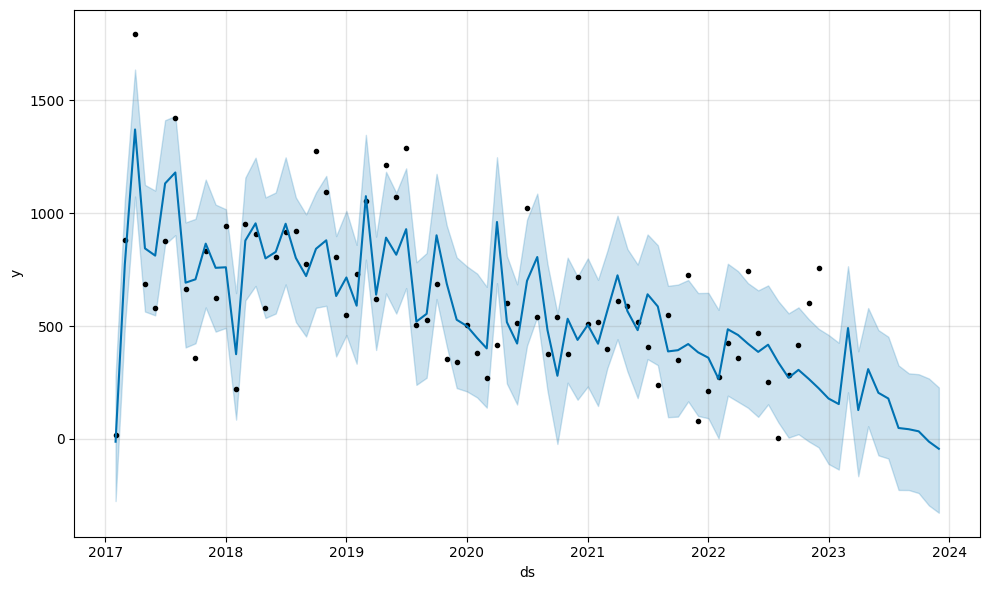

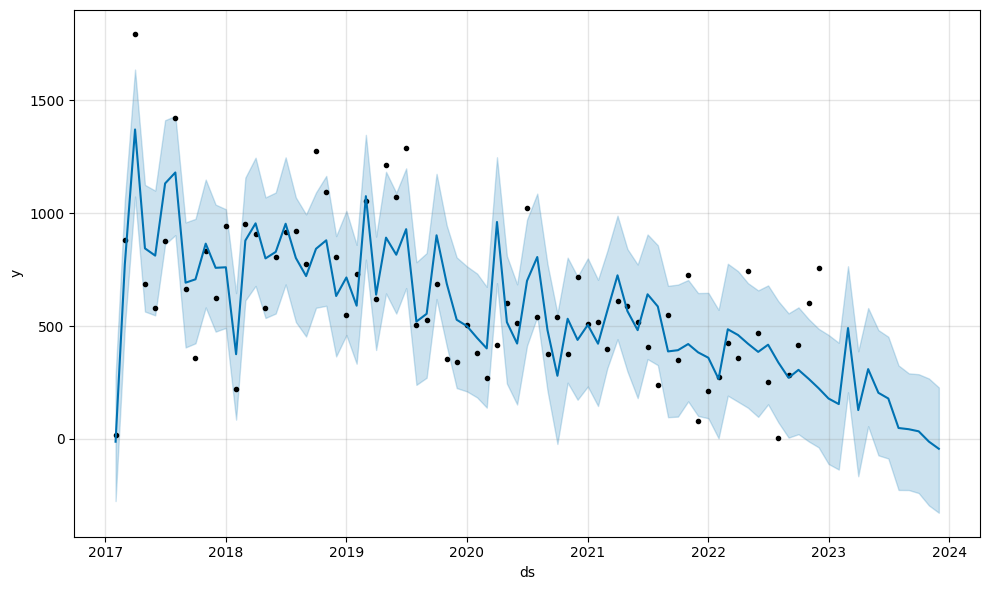

In [106]:
# Adjust Prophet model with smoother trend sensitivity
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.01)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Add monthly seasonality if applicable
model.fit(prophet_data)

# Make predictions
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Evaluate and plot
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[l4_filler['Month']]
actual = l4_filler.set_index('Month')
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

model.plot(forecast)

## Experimenting with using less training Data 2019 - 2023

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/k8rrqv5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/3z8y6l_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71936', 'data', 'file=/tmp/tmpd1hzcq62/k8rrqv5c.json', 'init=/tmp/tmpd1hzcq62/3z8y6l_2.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelgxkur6ka/prophet_model-20241106062808.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:28:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 30891.347617496776
R-squared: 0.5631539543665127


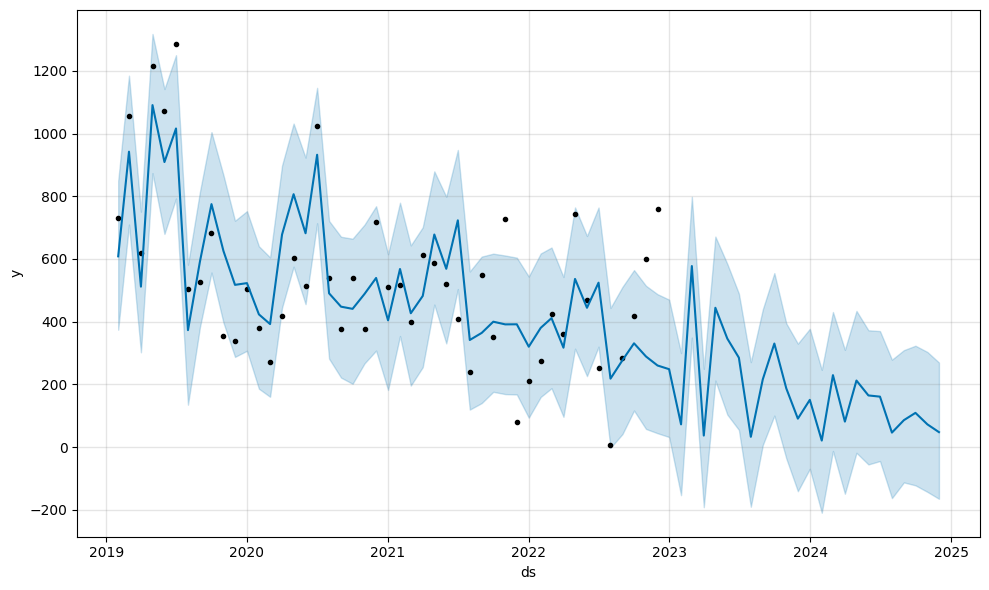

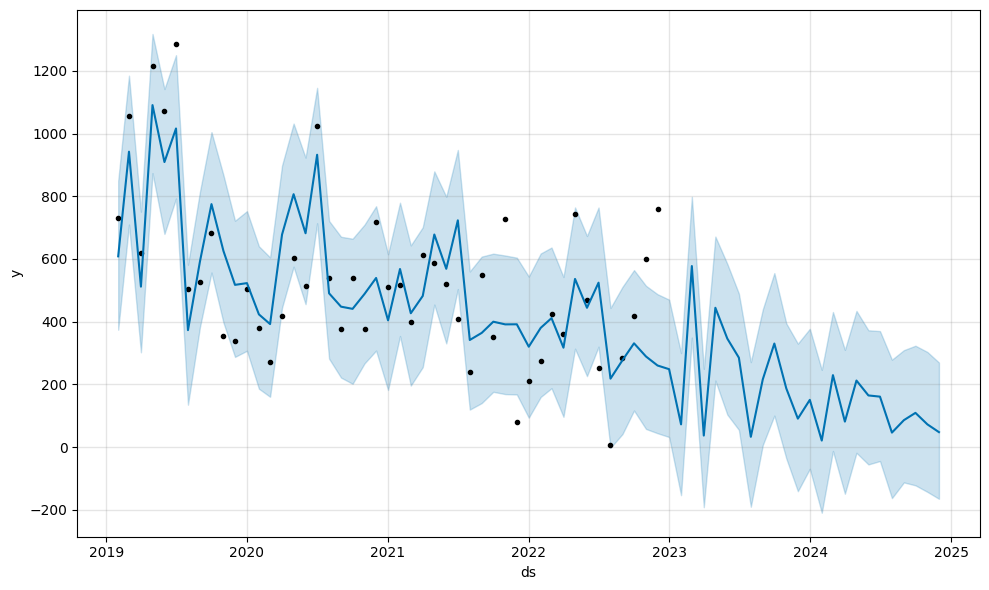

In [107]:
l4_filler = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE') &
    (df['Month'] < '2023-01-01') &
    (df['Month'] > '2019-01-01')
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
l4_filler = l4_filler.reset_index()

l4_filler['Month'] = pd.to_datetime(l4_filler['Month'])

# Prepare the data for Prophet
prophet_data = l4_filler.rename(columns={'Month': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

# Hyperparameter Tuning
changepoints = ['2021-09-01', '2022-09-01']

# Fit the Prophet model
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.1, changepoints=changepoints)
model.fit(prophet_data)

# Make a future DataFrame for predictions (for the next 12 months)
future = model.make_future_dataframe(periods=24, freq='M')

# Make predictions
forecast = model.predict(future)

# Evaluate the model
# Align the predictions with actual data
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[l4_filler['Month']]
actual = l4_filler.set_index('Month')

# Calculate performance metrics
mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

# Output results
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
model.plot(forecast)

## Pearson Correlation between Breakdown and Maitenance Time Series
Doing this we can identify which replacements are associated with which breakdowns so that we can prepare more effectively for upcoming maitenance

In [108]:
grouped_data = df.groupby(['PRODUCTION_LOCATION','EQUIPMENT_DESC'])['MAINTENANCE_ACTIVITY_TYPE'].count()
# Reset the index to convert the result to a DataFrame
grouped_data = grouped_data.reset_index()

# Rename the count column
grouped_data = grouped_data.rename(columns={'MAINTENANCE_ACTIVITY_TYPE': 'Activity_Count'})

df_for_list = grouped_data[grouped_data['Activity_Count']> 500]
equipment_list = df_for_list['EQUIPMENT_DESC'].tolist()

grouped_data = df.groupby('FUNCTIONAL_AREA_NODE_2_MODIFIED')['ACTUAL_WORK_IN_MINUTES'].sum()
grouped_data = grouped_data.reset_index()
grouped_data.sort_values(by='ACTUAL_WORK_IN_MINUTES', ascending=False)

# Rename the count column
grouped_data = grouped_data.rename(columns={'MAINTENANCE_ACTIVITY_TYPE': 'Activity_Count'})

pearson_breakdown_list = grouped_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].tolist()

In [109]:
def compute_truncated_pearson(list1, list2):
    # Truncate the lists to the same length
    min_len = min(len(list1), len(list2))
    truncated_list1 = list1[:min_len]
    truncated_list2 = list2[:min_len]

    # Compute Pearson correlation
    correlation, p_value = pearsonr(truncated_list1, truncated_list2)
    return correlation, p_value

def iterative_pearson_correlation():
    # Initialize the results list before the loops
    results_list = []

    # Get unique filter values from each dataframe
    filter_values1 = equipment_list  # Assuming this is defined
    filter_values2 = pearson_breakdown_list  # Assuming this is defined

    for filter1 in filter_values1:
        equip_plot_df = df[df['EQUIPMENT_DESC'] == filter1].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
        equip_plot_df = equip_plot_df.reset_index()
        equip_plot_df = equip_plot_df[(equip_plot_df['Month'] >= '2018-01-01') & (equip_plot_df['Month'] <= '2024-06-01')]
        replacement_list = equip_plot_df['ACTUAL_WORK_IN_MINUTES'].tolist()

        for filter2 in filter_values2:
            breakdown_plot_df = df[df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == filter2].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
            breakdown_plot_df = breakdown_plot_df.reset_index()
            breakdown_plot_df = breakdown_plot_df[(breakdown_plot_df['Month'] >= '2018-01-01') & (breakdown_plot_df['Month'] <= '2024-06-01')]
            breakdown_list = breakdown_plot_df['ACTUAL_WORK_IN_MINUTES'].tolist()

            # Check if both lists have at least 2 elements
            if len(replacement_list) >= 2 and len(breakdown_list) >= 2:
                # Compute Pearson correlation
                correlation, p_value = compute_truncated_pearson(replacement_list, breakdown_list)
                # print(f"Correlation between {filter1} and {filter2}: {correlation}, p-value: {p_value}")

                # Append results to the results list
                results_list.append({
                    'Filter1': filter1,
                    'Filter2': filter2,
                    'Correlation': correlation,
                    'P-Value': p_value
                })
            else:
              pass
                # Log the case where the lists are too short
                # print(f"Skipping correlation for {filter1} and {filter2} due to insufficient data.")

    # Convert results list to DataFrame after processing all combinations
    results_df = pd.DataFrame(results_list)
    return results_df

# Call the function
results_df = iterative_pearson_correlation()

# Display the results DataFrame
# print(results_df)

In [110]:
results_df[results_df['Correlation']> 0.6].sort_values(by='Correlation', ascending = False)

Filter1                    Filter2  Correlation  \
980   L4 FILLER_ROTARY_CAN_100_VALVE            ROTARY_CAN_LINE     0.965534   
569    L2 FILLER_ROTARY_BTL_45_VALVE             PETBOTTLELINES     0.961088   
794   L3 FILLER_ROTARY_BTL_100_VALVE             PETBOTTLELINES     0.943665   
1084                 L4 WARMER_SPRAY               CHEMICALROOM     0.943336   
634         L2 PALLETIZER_LINE 2_PAI               CHEMICALROOM     0.943178   
...                              ...                        ...          ...   
851                L3 LABELER_ROTARY         SYRUP/BLENDINGROOM     0.606924   
1185           LINE 1 LABELER_ROTARY                    HEATING     0.605472   
1073                L4 SEAMER_ROTARY            SHOP/REPAIRAREA     0.604210   
1022                  L4 PACKER_CASE  QUALITYASSURANCEEQUIPMENT     0.602978   
1046                L4 SEAMER_ROTARY          FILLER_ROTARY_CAN     0.602332   

           P-Value  
980   3.532630e-46  
569   3.273977e-44  
794   3.032010e-38  
1084  1.423673e-03  
634   1.433490e-03  
...            ...  
851   4.878791e-09  
1185  4.292643e-09  
1073  5.952182e-09  
1022  6.510527e-09  
1046  6.822550e-09  

[106 rows x 4 columns]

## Looking at overlapping trends of the highest correlated breakdowns/equipment replacement
Here we can see graphs that have 2 time series, one which is the breakdown (functional_area_node_2) and one of which is the equipment replacement (equipment_desc). They are the 10 most highly correlated equipment replacements and breakages.

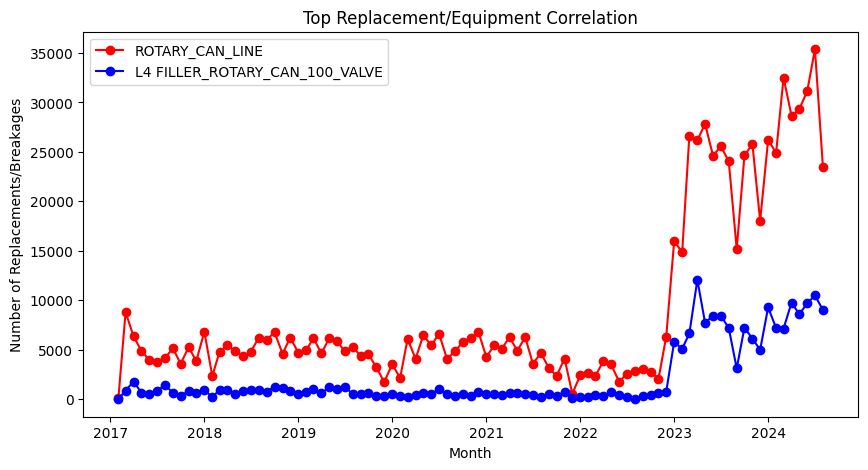

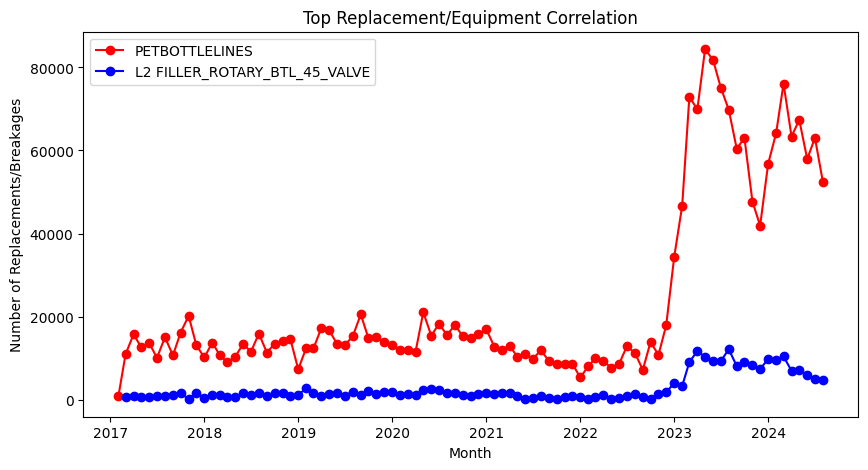

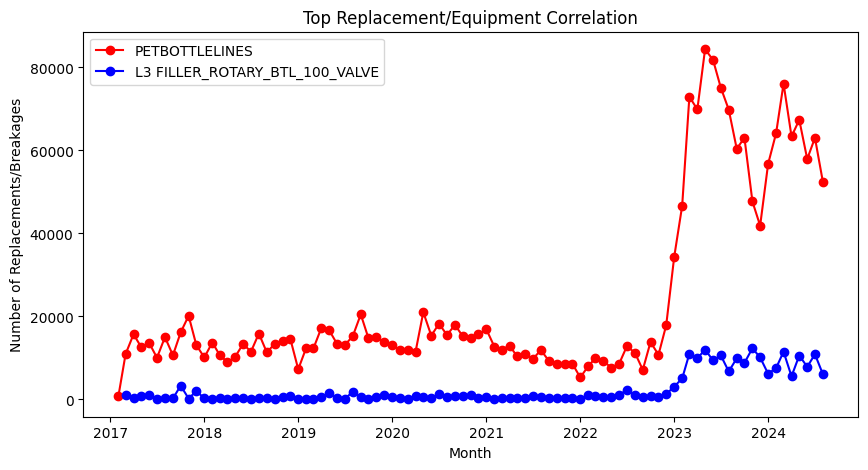

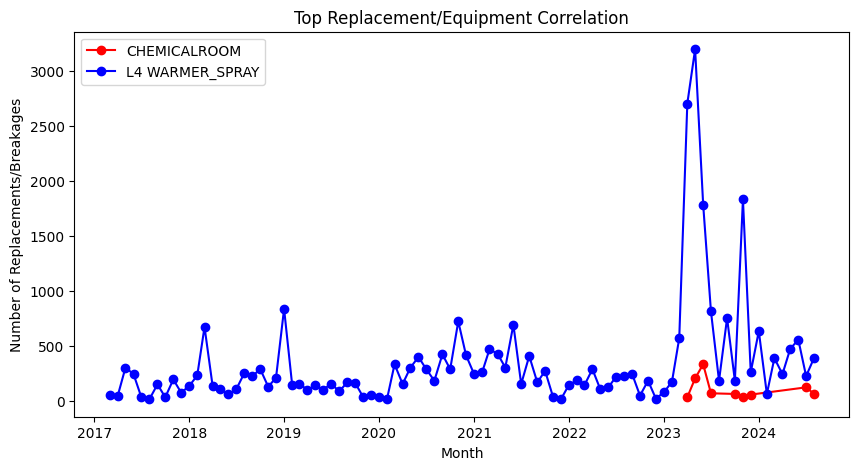

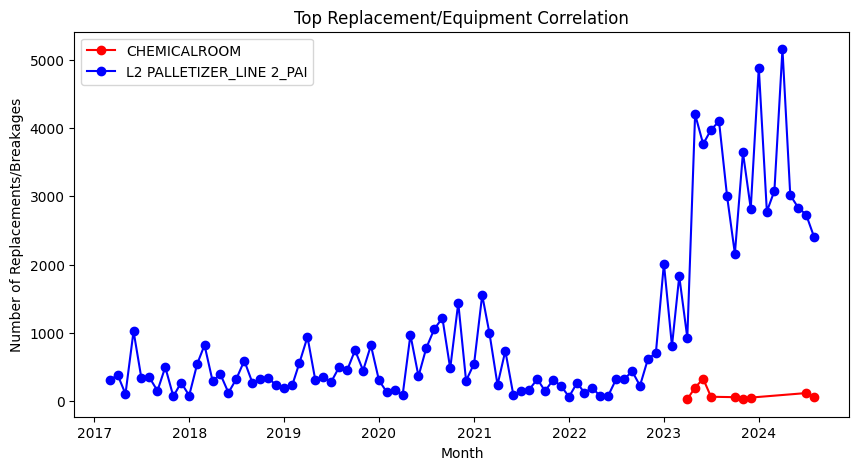

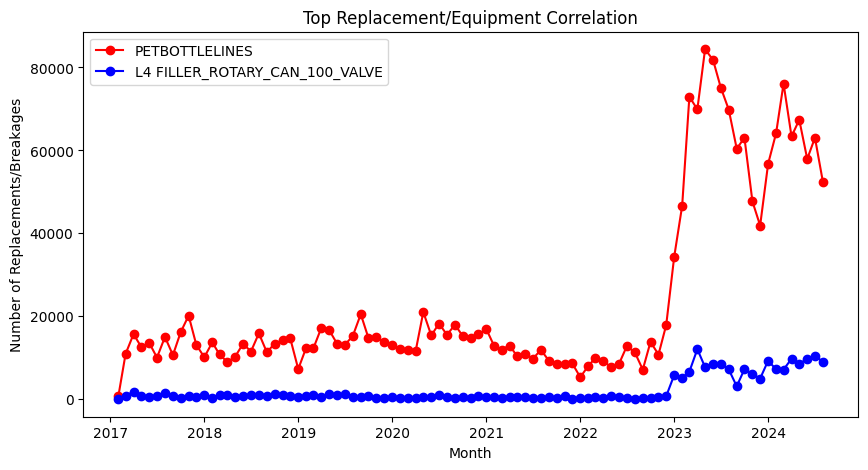

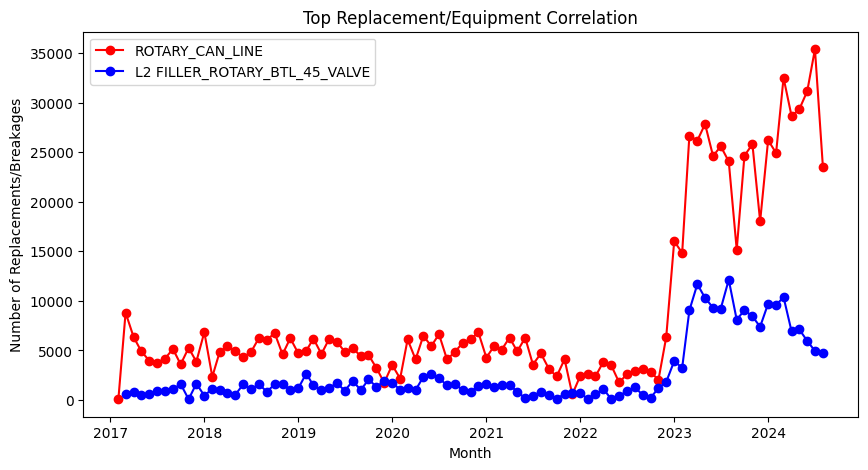

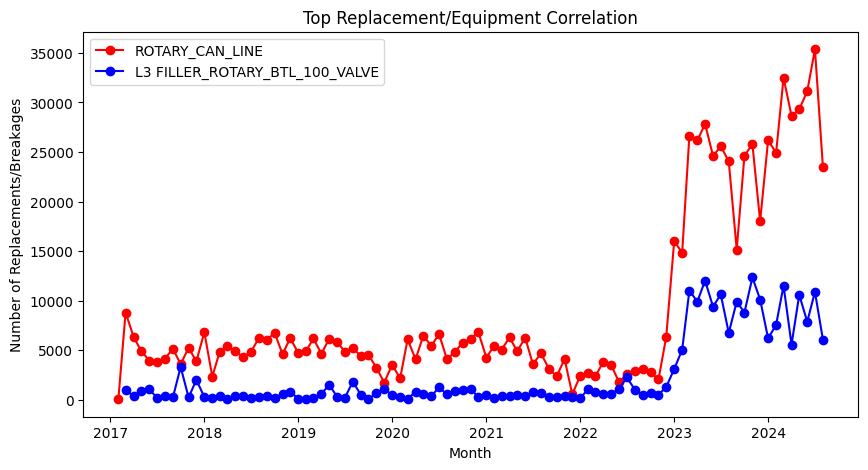

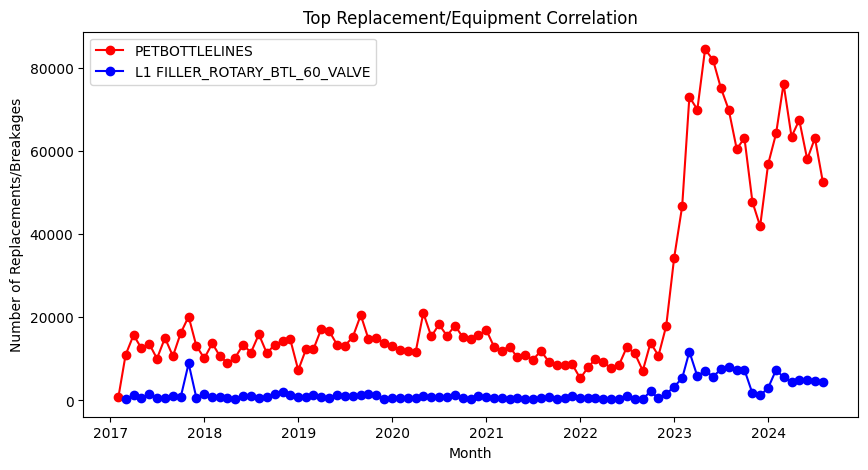

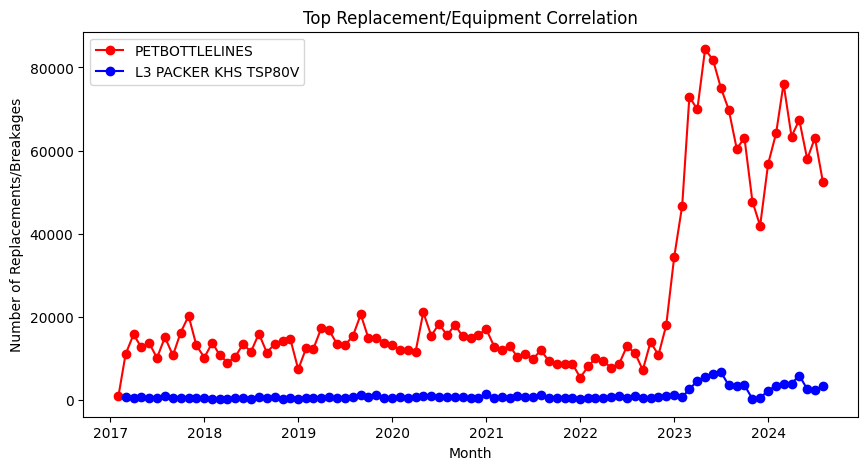

In [111]:
top_ten = results_df[results_df['Correlation']> 0.6].sort_values(by='Correlation', ascending = False).head(10)
top_ten_equipment = top_ten['Filter1'].tolist()
top_ten_breakage = top_ten['Filter2'].tolist()

for i in range(10):
    plot_df = df[df['EQUIPMENT_DESC'] == top_ten.iloc[i,0]].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
    plot_df = plot_df.reset_index()
    plt.figure(figsize=(10, 5))  # Set the figure size
    break_plot_df = df[df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == top_ten.iloc[i,1]].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
    break_plot_df = break_plot_df.reset_index()
    plt.plot(break_plot_df['Month'], break_plot_df['ACTUAL_WORK_IN_MINUTES'], label=f'{top_ten.iloc[i,1]}', marker='o', linestyle='-', color='r')
    plt.plot(plot_df['Month'], plot_df['ACTUAL_WORK_IN_MINUTES'], label=f'{top_ten.iloc[i,0]}', marker='o', linestyle='-', color='b')
    plt.title('Top Replacement/Equipment Correlation')
    plt.xlabel('Month')
    plt.ylabel('Number of Replacements/Breakages')
    plt.legend()
    plt.show()

# Additional Modeling

## Unplanned vs Planned Maintenance

The following will provide insight into what planned maintenance might look like in place of unplanned. If we can predict when to do maintenace further ahead, we can save time in jobs that are on average faster when planned vs unplanned.

In [112]:
# Step 1: Aggregate the DataFrame by calculating mean and count for each group
agg_df = df.groupby(['PRODUCTION_LOCATION', 'MAINTENANCE_ACTIVITY_TYPE', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID']).agg(
    average_minutes = ('ACTUAL_WORK_IN_MINUTES', 'mean'),  # Calculate the average work time in minutes for each group
    count = ('ACTUAL_WORK_IN_MINUTES', 'count')            # Calculate the count of work orders for each group
).reset_index()

# Step 2: Pivot the aggregated DataFrame to separate Planned and Unplanned maintenance types
pivoted_df = agg_df.pivot_table(
    index=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID'],  # Use these columns as the index
    columns='MAINTENANCE_ACTIVITY_TYPE',                                              # Spread values by 'MAINTENANCE_ACTIVITY_TYPE'
    values=['average_minutes', 'count']                                               # Pivot both average and count values
).reset_index()

# Step 3: Flatten multi-level column names
# Join multi-level column names with an underscore and remove any extra spaces
pivoted_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivoted_df.columns]

# Step 4: Calculate the percentage time saved by planned vs. unplanned maintenance
pivoted_df['time_saved'] = (
    (pivoted_df['average_minutes_Unplanned'] - pivoted_df['average_minutes_Planned']) / pivoted_df['average_minutes_Unplanned'] * 100
)

# Step 5: Remove any trailing underscores in column names for consistency
pivoted_df = pivoted_df.rename(columns=lambda x: x.rstrip('_'))

# Step 6: Sort by the count of unplanned maintenance in descending order and display the top results
pivoted_df.sort_values(by='count_Unplanned', ascending=False).head()


PRODUCTION_LOCATION FUNCTIONAL_AREA_NODE_2_MODIFIED  EQUIPMENT_ID  \
149                 COTA                         CANLINE   300025792.0   
228                 COTA                         CANLINE   300115000.0   
1993                ROMA                 SHOP/REPAIRAREA   300017655.0   
54                  COTA                      BOTTLELINE   300026891.0   
2788              SUZUKA                   PETBOTTLELINE   300009177.0   

      average_minutes_Planned  average_minutes_Unplanned  count_Planned  \
149                 65.223529                 114.049250          782.0   
228                 59.367360                  94.478462          625.0   
1993                38.249300                 111.770785         1286.0   
54                 110.422140                  88.643694          271.0   
2788                81.606704                 178.558460          179.0   

      count_Unplanned  time_saved  
149            3801.0   42.811084  
228            3120.0   37.163075  
1993           2930.0   65.778803  
54             2783.0  -24.568523  
2788           2104.0   54.296927

In [113]:
# use sample plant, area, and equipment that could eventually be used in a pipeline
selected_plant = 'COTA'
selected_func_area = 'CANLINE'
selected_equipment = 300025792.0

selected_columns = ['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'MAINTENANCE_ACTIVITY_TYPE', 'EQUIPMENT_ID', 'START_YEAR_WEEK', 'ACTUAL_WORK_IN_MINUTES']

df_top_union = df[selected_columns]


In [114]:
# create datagrame for prophet
selection_aggs = df_top_union[
    (df_top_union['PRODUCTION_LOCATION'] == selected_plant) &
    (df_top_union['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == selected_func_area) &
    (df_top_union['EQUIPMENT_ID'] == selected_equipment)
    ].groupby(
        df_top_union['START_YEAR_WEEK']
    ).agg(
        y = ('EQUIPMENT_ID', 'count')
    ).reset_index().rename(columns={'START_YEAR_WEEK': 'ds'})

# rename start date to ds
selection_aggs.head()

ds   y
0 2017-10-30   6
1 2017-11-06   9
2 2017-11-13  13
3 2017-11-20   7
4 2017-11-27  11

In [115]:
# prophet model
model = Prophet()
model.fit(selection_aggs)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/71h_og54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1hzcq62/j8cgzuld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84545', 'data', 'file=/tmp/tmpd1hzcq62/71h_og54.json', 'init=/tmp/tmpd1hzcq62/j8cgzuld.json', 'output', 'file=/tmp/tmpd1hzcq62/prophet_modelon4cox09/prophet_model-20241106063006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:30:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [116]:
future = model.make_future_dataframe(periods=48, freq='W')

forecast = model.predict(future)

# Display the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds      yhat  yhat_lower  yhat_upper
0 2017-10-30  4.672658   -3.829863   13.205164
1 2017-11-06  5.380344   -3.044046   13.222286
2 2017-11-13  5.358625   -2.969770   14.130145
3 2017-11-20  5.512541   -3.117942   13.796772
4 2017-11-27  6.285761   -2.044787   14.557524

From the agreggated values for planned vs unplanned, we can use these to put against our yhat output to predict time differences.

In [117]:
avg_mins_planned = pivoted_df[
    (pivoted_df['PRODUCTION_LOCATION'] == selected_plant) &
    (pivoted_df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == selected_func_area) &
    (pivoted_df['EQUIPMENT_ID'] == selected_equipment)
]['average_minutes_Planned'].iloc[0]

avg_mins_planned

65.22352941176472

In [118]:
avg_mins_unplanned = pivoted_df[
    (pivoted_df['PRODUCTION_LOCATION'] == selected_plant) &
    (pivoted_df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == selected_func_area) &
    (pivoted_df['EQUIPMENT_ID'] == selected_equipment)
]['average_minutes_Unplanned'].iloc[0]

avg_mins_unplanned

114.0492501973165

In [119]:
# we need to marry the original data with the predicted data
df_bottom_union = forecast[['ds', 'yhat']]
df_bottom_union['PRODUCTION_LOCATION'] = selected_plant
df_bottom_union['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = selected_func_area
df_bottom_union['MAINTENANCE_ACTIVITY_TYPE'] = 'Planned'
df_bottom_union['EQUIPMENT_ID'] = selected_equipment
df_bottom_union['ACTUAL_WORK_IN_MINUTES'] = df_bottom_union['yhat'] * avg_mins_planned
df_bottom_union['ACTUAL_Unplanned'] = df_bottom_union['yhat'] * avg_mins_unplanned
df_bottom_union['source'] = 'predicted'

# for visualization purposes, I will be cutting off the future dataframes past dates
max_date = max(selection_aggs['ds'])

df_bottom_union = df_bottom_union[(df_bottom_union['ds'] > max_date)].drop('yhat', axis=1)

In [120]:
df_top_union_final = df_top_union[
    (df['PRODUCTION_LOCATION'] == selected_plant) &
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == selected_func_area) &
    (df['EQUIPMENT_ID'] == selected_equipment)
    ]

df_top_union_final['source'] = 'real'

df_top_union_final = df_top_union_final.rename(columns={'START_YEAR_WEEK': 'ds'})

# Concatenate the two DataFrames
df_union = pd.concat([df_bottom_union, df_top_union_final], ignore_index=True).sort_values(by='ds')

In [121]:
df_union.head()

ds PRODUCTION_LOCATION FUNCTIONAL_AREA_NODE_2_MODIFIED  \
2125 2017-10-30                COTA                         CANLINE   
1234 2017-10-30                COTA                         CANLINE   
317  2017-10-30                COTA                         CANLINE   
869  2017-10-30                COTA                         CANLINE   
3408 2017-10-30                COTA                         CANLINE   

     MAINTENANCE_ACTIVITY_TYPE  EQUIPMENT_ID  ACTUAL_WORK_IN_MINUTES  \
2125                 Unplanned   300025792.0                    90.0   
1234                 Unplanned   300025792.0                    60.0   
317                  Unplanned   300025792.0                    30.0   
869                  Unplanned   300025792.0                    30.0   
3408                 Unplanned   300025792.0                    60.0   

      ACTUAL_Unplanned source  
2125               NaN   real  
1234               NaN   real  
317                NaN   real  
869                NaN   real  
3408               NaN   real

In [122]:
df_union.tail()

ds PRODUCTION_LOCATION FUNCTIONAL_AREA_NODE_2_MODIFIED  \
43 2025-06-29                COTA                         CANLINE   
44 2025-07-06                COTA                         CANLINE   
45 2025-07-13                COTA                         CANLINE   
46 2025-07-20                COTA                         CANLINE   
47 2025-07-27                COTA                         CANLINE   

   MAINTENANCE_ACTIVITY_TYPE  EQUIPMENT_ID  ACTUAL_WORK_IN_MINUTES  \
43                   Planned   300025792.0              604.273303   
44                   Planned   300025792.0              561.346619   
45                   Planned   300025792.0              667.653469   
46                   Planned   300025792.0              794.520557   
47                   Planned   300025792.0              851.345364   

    ACTUAL_Unplanned     source  
43       1056.626616  predicted  
44        981.565420  predicted  
45       1167.452577  predicted  
46       1389.291175  predicted  
47       1488.654498  predicted

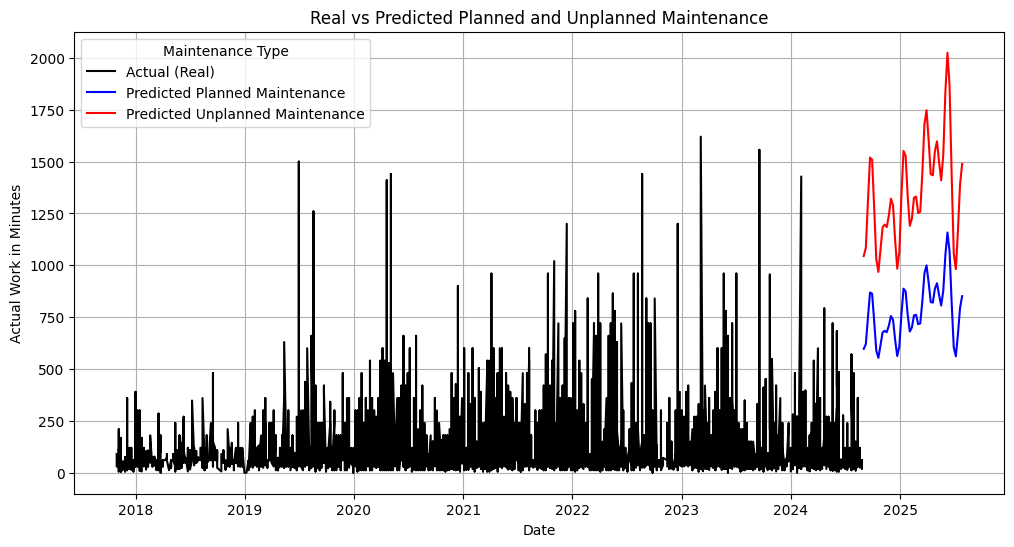

In [123]:
# Create plot
plt.figure(figsize=(12, 6))

# Plot real values as a single line
plt.plot(df_union[df_union['source'] == 'real']['ds'], df_union[df_union['source'] == 'real']['ACTUAL_WORK_IN_MINUTES'],
         label='Actual (Real)', color='black')

# Plot predicted planned maintenance
plt.plot(df_union[df_union['source'] == 'predicted']['ds'], df_union[df_union['source'] == 'predicted']['ACTUAL_WORK_IN_MINUTES'],
         label='Predicted Planned Maintenance', color='blue')

# Plot predicted unplanned maintenance
plt.plot(df_union[df_union['source'] == 'predicted']['ds'], df_union[df_union['source'] == 'predicted']['ACTUAL_Unplanned'],
         label='Predicted Unplanned Maintenance', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Actual Work in Minutes')
plt.title('Real vs Predicted Planned and Unplanned Maintenance')
plt.legend(title="Maintenance Type")
plt.grid(True)
plt.show()

This visualizes the difference of time when maintenance is unplanned vs planned.

Using a Random Forest, we can compliment and assess each piece of equipments expiry date using a target variable called Date_Diff.
The goal here is to get an MAE within 7 days for each location as that will help align maintenance tasks for equipment that is predicted to fail that week.

## Tracking the life of Equipment ID
Prep of a data frame with unique values to track life cycle of an EQUIPMENT_ID


In [124]:
df2 = df.copy()
print(f"{len(df2['EQUIPMENT_ID']):_}")

# Drop NaN
# Keep rows where 'Functional_area_node_2' is not NaN even if 'EQUIPMENT_ID' is NaN
df2 = df2[~df2['FUNCTIONAL_AREA_NODE_2_MODIFIED'].isna() | ~df2['EQUIPMENT_ID'].isna()]
# Drop rows where both 'EQUIPMENT_ID' and 'Functional_area_node_2' are NaN
df2 = df2.dropna(subset=['EQUIPMENT_ID', 'FUNCTIONAL_AREA_NODE_2_MODIFIED'], how='all')

# Concat for unique life cycles
df2['Life_ID'] = df2['EQUIPMENT_ID'].astype(str) + ' ' + df2['PRODUCTION_LOCATION'] + ' '  + df2['ACTUAL_START_TIME'].astype(str) + df2['EXECUTION_START_DATE'].astype(str)
df2 = df2[['Life_ID','EQUIPMENT_ID','PRODUCTION_LOCATION','ACTUAL_START_TIME','EXECUTION_START_DATE','ACTUAL_WORK_IN_MINUTES','MAINTENANCE_ACTIVITY_TYPE','FUNCTIONAL_AREA_NODE_2_MODIFIED','FUNCTIONAL_AREA_NODE_3_MODIFIED','EQUIPMENT_DESC']].sort_values(by=['EQUIPMENT_ID','EXECUTION_START_DATE'], ascending=True)
print('Before and After of Removing NA')
print(f"{len(df2['EQUIPMENT_ID']):_}")

1_406_338
Before and After of Removing NA
291_795


## Match ID and Dates


In [125]:
df2['ID'] = df2['Life_ID'].str.extract(r'(\d+\.\d+)')[0]
df2.reset_index(drop=True, inplace=True)
df2['EXECUTION_START_DATE'] = pd.to_datetime(df2['EXECUTION_START_DATE'])

## Subtract Start dates and Death date of Equipment_ID


Grouping by Equipment_ID and sorting by date, allows us to subtract the next maintenance occurrence for that equipment. Thus giving us the life expectancy for each equipment.

In [126]:
# Define a function to check ID prefix and calculate date differences
def calculate_date_difference(df2):
    df['Date_Diff'] = None
    for i in range(1, len(df2)):
        if df2.loc[i, 'ID'][:2] == df2.loc[i-1, 'ID'][:2]:
            df2.loc[i, 'Date_Diff'] = (df2.loc[i, 'EXECUTION_START_DATE'] - df2.loc[i-1, 'EXECUTION_START_DATE']).days
    return df2

df2 = calculate_date_difference(df2)

# Group by 'EQUIPMENT_ID' and calculate the mean
average_date_diff = df2.groupby('EQUIPMENT_ID')['Date_Diff'].mean().reset_index()
average_date_diff.rename(columns={'Date_Diff': 'Average_Date_Diff'}, inplace=True)
df2 = df2.merge(average_date_diff, on='EQUIPMENT_ID', how='left')

# Date_Diff, initial row error of being negative
def set_date_diff(row):
    if row['Date_Diff'] < 0:
        if row['Average_Date_Diff'] < 0:
            return 0
        else:
            return row['Average_Date_Diff']
    return row['Date_Diff']

df2['Date_Diff'] = df2.apply(set_date_diff, axis=1)
df2.drop(columns=['Average_Date_Diff'], inplace=True)

# Encoding
df_encoded = df2.copy()

le = LabelEncoder()
df_encoded['EQUIPMENT_DESC_encoded'] = le.fit_transform(df2['EQUIPMENT_DESC'])
df_encoded['MAINTENANCE_ACTIVITY_TYPE'] = le.fit_transform(df2['MAINTENANCE_ACTIVITY_TYPE'])
df_encoded['PRODUCTION_LOCATION_encoded'] = le.fit_transform(df2['PRODUCTION_LOCATION'])
df_encoded['FUNCTIONAL_AREA_NODE_2_MODIFIED_encoded'] = le.fit_transform(df2['FUNCTIONAL_AREA_NODE_2_MODIFIED'])
df_encoded['FUNCTIONAL_AREA_NODE_3_MODIFIED_encoded'] = le.fit_transform(df2['FUNCTIONAL_AREA_NODE_3_MODIFIED'])

df_encoded['ACTUAL_START_TIME'] = pd.to_datetime(df_encoded['ACTUAL_START_TIME'], errors='coerce')
df_encoded['EXECUTION_START_DATE'] = pd.to_datetime(df_encoded['EXECUTION_START_DATE'], errors='coerce')
df_encoded['start_hour'] = df_encoded['ACTUAL_START_TIME'].dt.hour
df_encoded['execution_hour'] = df_encoded['EXECUTION_START_DATE'].dt.hour
df_encoded['execution_day'] = df_encoded['EXECUTION_START_DATE'].dt.day


#### Random Forest Model

The Random Forest model will give us a new data frame with the life expectancy of each equipment. This will help apply findings to the Prophet model and predict exact equipment failure.

In [127]:
warnings.filterwarnings('ignore')


# Loop through each unique production location
for location in df_encoded['PRODUCTION_LOCATION'].unique():
    # Filter the DataFrame for the current location
    df_location = df_encoded[df_encoded['PRODUCTION_LOCATION'] == location]
    # Filter equipment IDs with a count of at least 100
    equipment_counts = df_location['EQUIPMENT_ID'].value_counts()
    equipment_ids_to_keep = equipment_counts[equipment_counts >= 200].index
    df_location = df_location[df_location['EQUIPMENT_ID'].isin(equipment_ids_to_keep)]

    # Convert any time columns to datetime format and extract hour if needed
    df_location['ACTUAL_START_TIME'] = pd.to_datetime(df_location['ACTUAL_START_TIME'], errors='coerce')
    df_location['EXECUTION_START_DATE'] = pd.to_datetime(df_location['EXECUTION_START_DATE'], errors='coerce')
    df_location['start_hour'] = df_location['ACTUAL_START_TIME'].dt.hour
    df_location['execution_hour'] = df_location['EXECUTION_START_DATE'].dt.hour
    df_location['execution_day'] = df_location['EXECUTION_START_DATE'].dt.day
    df_location.drop(columns=['ACTUAL_START_TIME', 'EXECUTION_START_DATE'], inplace=True)

    # NA's or negatives in date_diff
    average_date_diff = df_encoded.groupby('EQUIPMENT_ID')['Date_Diff'].mean().reset_index()
    average_date_diff.rename(columns={'Date_Diff': 'Average_Date_Diff'}, inplace=True)
    df_encoded = df_encoded.merge(average_date_diff, on='EQUIPMENT_ID', how='left')
    def set_date_diff(row):
        if row['Date_Diff'] < 0:
            if row['Average_Date_Diff'] < 0:
                return 1
            else:
                return row['Average_Date_Diff']
        return row['Date_Diff']
    df_encoded['Date_Diff'] = df_encoded.apply(set_date_diff, axis=1)
    df_encoded.drop(columns=['Average_Date_Diff'], inplace=True)


    # Features and target variable
    X = df_location[['EQUIPMENT_ID', 'start_hour', 'execution_hour','execution_day', 'ACTUAL_WORK_IN_MINUTES',
                     'ID', 'EQUIPMENT_DESC_encoded', 'PRODUCTION_LOCATION_encoded',
                     'FUNCTIONAL_AREA_NODE_2_MODIFIED_encoded','FUNCTIONAL_AREA_NODE_3_MODIFIED_encoded','MAINTENANCE_ACTIVITY_TYPE',]]
    y = df_location['Date_Diff']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

    # Train model
    model = RandomForestRegressor(min_samples_leaf=10, min_samples_split=5,max_depth=10, n_estimators=600, random_state=46)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f"Location: {location}")
    print("MAE (Days +-):", round(mae, 2))
    print("RMSE:", rmse)
    print("R2:", r2)

    print()

    # Predict on the entire dataset for this location
    df_location['Predicted_Date_Diff'] = model.predict(X)

Location: COTA
MAE (Days +-): 3.39
RMSE: 6.498004887574274
R2: 0.15612099695088577

Location: ROMA
MAE (Days +-): 2.23
RMSE: 5.428937827834043
R2: 0.06474757751638938

Location: MONZA
MAE (Days +-): 3.66
RMSE: 7.1305668042032435
R2: 0.20167260177588875

Location: SUZUKA
MAE (Days +-): 3.81
RMSE: 12.065436743043387
R2: 0.023395419087198555

Location: SILVERSTONE
MAE (Days +-): 4.32
RMSE: 8.788161143739421
R2: 0.11301573792043695

Location: MONACO
MAE (Days +-): 4.14
RMSE: 10.602426944945858
R2: -0.007314627371970195



With the MAE's within 7 days, we can better assess maintenance schedules and life expectancy for each equipment. The rollout of this model will cause data drift and the model will need to be retrained as operations should improve and so will the life expectancy prediction of equipment.

# Key Ideas and Technical Points to Discuss


**Identify a performance benchmark.  What is a minimum threshold for model performance?**
* When it comes to the Random Forest model, the goal is to get as much maintenance done within 7 days.

If the model can get an MAE within 7 days for a piece of equipment, we can consider that a success. A rolling prediction will help align maintenance schedules for pieces that will break down that week.

**Identify appropriate models to explore (given the business problem and the project objective).**
* In predictive maintenance, Swire’s equipment may exhibit seasonal usage patterns (life expectancy, frequent downtimes and startups during certain periods).

Prophet’s handling of daily, weekly, and yearly seasonality allows it to capture these cyclical trends without extensive tuning.
A Random Forest model will get the specifics for each locations equipment and its predicted failure
With the granularity of each equipment at each location, we need specifics on the lifecycle of each equipment and predict its failure point. The pieces of equipment with the most common breakage and shortest lifespan will need parts ordered. The longer lasting items will require less replacement and less inventory. The goal is to have a rolling cycle of these predictions and as maintenance schedules improve, so will the accuracy and life expectancy of parts.

**Do additional data preparation and feature engineering as necessary.**
* Feature Engineering included date and time factoring, as well as trimming down data based on frequencies and counts.

For the Random Forest, there was a need for factoring. The time and date of when maintenance occurred made it difficult for the model. It was best to factor these and have common values for the model to use. The Date_Diff had issues, because as we subtract the next occurrence of maintenance for a piece of equipment. We run into an issue of negative values. Grouping by Equipment_ID and sorting by date, causes the first row to use the date from the previous equipment and date which gives negative values. To combat this, the average for the equipment ID was applied.

**Optimize model performance with hyperparameter tuning, if appropriate.**
Prophet offers multiple perspectives—daily, weekly, and yearly seasonalities, as well as the ability to handle custom seasonalities and holiday effects. Selecting and refining these views based on Swire’s historical data, you can pinpoint the most suitable model configuration to enhance forecast precision.

The tuning for the Random Forest included feature engineering, sampling sizing, seed setting, and splitting. Without overfitting and creating a costly model, the Random Forest’s hyperparameters of 600 estimators and max depth of 10. Helped identify breakage within 3-4 days, which was below our expected 7.

**Evaluate the strengths and weaknesses of each model and select the best one.**

*Strengths of Prophet*

Prophet’s design makes it relatively easy to implement and quick to train on moderately large datasets.
Interpretability of Prophet makes it easy to pass off to stakeholders

*Weaknesses of Prophet*

Prophet’s downside is dependency on multiplicative seasonal components and is limited where data has non-standard seasonality. This can lead to low R-squared scores, especially if the data is highly nonlinear or complex
Limited parameter tuning which causes it to struggle to capture more complex dependencies in the data.

*Strengths of Random Forest*

This model is very easy to tune and apply metrics to
It is very robust as you can apply different techniques to make sure it will live in a production setting

*Weaknesses of Random Forest*

The interpretability in this context is not strong when compared to Prophet’s graphs and tolerance zones
It takes a higher level of statistics knowledge to understand the output
Prone to overfitting as the hyperparameters were self-adjusted

**Perform business validation of the model.  Are your results sufficient to solve the business problem?**
* To validate the Prophet model for predictive maintenance, it's essential to determine if its forecasts are practically usable within the business’s operational tolerances.

Business validation involves ensuring the model’s predictions align with established failure thresholds, maintenance lead times, and cost constraints for interventions. This means defining when predicted performance drops actually warrant action—whether a drop signifies routine degradation or potential failure. A pilot program with historical data can provide insights into potential cost savings, reductions in unscheduled downtime, and improvements in operational efficiency. By comparing results with past maintenance records, the business can confirm if the model provides timely, actionable forecasts that justify the investment, reducing unnecessary maintenance and avoiding costly equipment failures.   


# Conclusion

## Implications for the Lifecycle of Equipment
#### Maintenance Strategy Optimization:
Locations with lower MAE and RMSE values (ROMA) may benefit from more proactive maintenance strategies, utilizing predictive maintenance models to anticipate and schedule repairs effectively.

#### Risk Management:
High RMSE values and negative R² scores (like MONACO) signal a need for risk assessment and perhaps a shift towards more traditional maintenance approaches (like reactive maintenance) until better predictive accuracy is achieved.

#### Data-Driven Decisions:
Improving the quality and quantity of data across locations, along with advanced analytics, can lead to better predictions and ultimately a more reliable maintenance schedule, which aligns with the equipment lifecycle phases.

#### Investment in Technology:
Equipment with inconsistent predictive performance may require investment in monitoring technologies (sensors, IoT devices,RFID, GPS) to gather real-time data, improving the ability to predict failures accurately.


### Conclusion
The results from your predictive maintenance model serve as a foundation for developing effective maintenance strategies across various equipment locations. By focusing on continuous improvement of model performance through better data, feature engineering, and possibly integrating other data sources, you can enhance the reliability and efficiency of your equipment lifecycle management, ultimately leading to reduced downtime and maintenance costs.

In [128]:
#!cp "/content/drive/MyDrive/Colab Notebooks/Modeling-Katie.ipynb" ./
#!jupyter nbconvert "Modeling-Katie.ipynb" --to html